# ScVelo: rhombencephalon 

Analysis of healthy (unperturbed) rhomcephalon sample, with parameters established for telencephalon. Focus on cell state transitions, in particular for radial glia and neurons.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
#import bbknn

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import warnings
warnings.filterwarnings('ignore')

scanpy==1.7.2 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2


### Load datasets

Note: although I have two datasets for rhombencephalon (b7_cer and b18_rhom), previous analysis has shown that the two don't integrate well even with bbknn. This is likely because of technical artefact due to difference in 10x kit chemistry. Given that is the larger dataset with higher quality, I choose to focus only on b18 for the paper.   

In [21]:
#b7_cer = sc.read_loom("/local/Nina/10x_brains_trans/mapped_DR11_CR6/b7_cer/velocyto/b7_cer.loom")
b18_rhom = sc.read_loom("/local/Nina/10x_brains_trans/mapped_DR11_CR6/b18_rhom/velocyto/b18_rhom.loom")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
b18_rhom.var_names_make_unique()

#### Rename barcodes
For compatibility with my Seurat naming convention.  

In [23]:
b18_rhom_orig_barcode = b18_rhom.obs.index.values

barcode_data_suffix = []
for barcode in b18_rhom.obs.index.values:
    barcode_suffix = barcode.split(':')[1]
    barcode_suffix = barcode_suffix[:-1]
    barcode_suffix = 'B18.R_' + barcode_suffix + '-1'

    barcode_data_suffix.append(barcode_suffix)
    
barcode_data_suffix = np.array(barcode_data_suffix)
barcode_data_df = pd.DataFrame(barcode_data_suffix).set_index(0)
barcode_data_df = barcode_data_df.rename_axis(None)

b18_rhom.obs = barcode_data_df
b18_rhom.obs['orig_barcode'] = b18_rhom_orig_barcode

### Import and combine annotation

This is the annotation for cells that pass filtering criteria in Seurat as well as doublet removal. Therefore by selecting only for barcodes present in the annotated dataset, I can skip the usual filtering steps.  
The current annotation is complete for neurons & radial glia which are the most important cells for the trajectories, so all other cells will get excluded at this stage.  

In [24]:
annotation = pd.read_csv("/local/Nina/jupyterlab/brains_trans/ann_detailed.csv", index_col= 0)
annotation

Barcode Orig_ident Brain_reg_lib  \
B1.T_AAAGAGACGGATTC-1        B1.T_AAAGAGACGGATTC-1     b1_tel           tel   
B1.T_AAAGAGACTAGACC-1        B1.T_AAAGAGACTAGACC-1     b1_tel           tel   
B1.T_AAAGAGACTCTACT-1        B1.T_AAAGAGACTCTACT-1     b1_tel           tel   
B1.T_AAAGGCCTAGATCC-1        B1.T_AAAGGCCTAGATCC-1     b1_tel           tel   
B1.T_AAATACTGGAATAG-1        B1.T_AAATACTGGAATAG-1     b1_tel           tel   
...                                            ...        ...           ...   
B19.M_TTTGGTTAGGTTGAGC-1  B19.M_TTTGGTTAGGTTGAGC-1   b19_tdmr         whole   
B20.M_ATGGTTGTCGCTACAA-1  B20.M_ATGGTTGTCGCTACAA-1   b20_gfap         whole   
B20.M_GCATCTCCATAATCCG-1  B20.M_GCATCTCCATAATCCG-1   b20_gfap         whole   
B20.M_GGTTCTCCAAAGCTAA-1  B20.M_GGTTCTCCAAAGCTAA-1   b20_gfap         whole   
B20.M_TACAACGAGACATATG-1  B20.M_TACAACGAGACATATG-1   b20_gfap         whole   

                         Fixation    Celltype_major  \
B1.T_AAAGAGACGGATTC-1       fresh           Neurons   
B1.T_AAAGAGACTAGACC-1       fresh           Neurons   
B1.T_AAAGAGACTCTACT-1       fresh           Neurons   
B1.T_AAAGGCCTAGATCC-1       fresh           Neurons   
B1.T_AAATACTGGAATAG-1       fresh           Neurons   
...                           ...               ...   
B19.M_TTTGGTTAGGTTGAGC-1    fresh   Ependymal cells   
B20.M_ATGGTTGTCGCTACAA-1    fresh  Epithelial cells   
B20.M_GCATCTCCATAATCCG-1    fresh  Epithelial cells   
B20.M_GGTTCTCCAAAGCTAA-1    fresh  Epithelial cells   
B20.M_TACAACGAGACATATG-1    fresh  Epithelial cells   

                                       Celltype_detailed  \
B1.T_AAAGAGACGGATTC-1        Neurons glutamatargic (tel)   
B1.T_AAAGAGACTAGACC-1     Neurons gabaergic penkb+ (tel)   
B1.T_AAAGAGACTCTACT-1        Neurons glutamatargic (tel)   
B1.T_AAAGGCCTAGATCC-1     Neurons gabaergic pax6b+ (tel)   
B1.T_AAATACTGGAATAG-1                      Granule cells   
...                                                  ...   
B19.M_TTTGGTTAGGTTGAGC-1                 Ependymal cells   
B20.M_ATGGTTGTCGCTACAA-1                Epithelial cells   
B20.M_GCATCTCCATAATCCG-1                Epithelial cells   
B20.M_GGTTCTCCAAAGCTAA-1                Epithelial cells   
B20.M_TACAACGAGACATATG-1                Epithelial cells   

                         Celltype_detailed_short  Keep_in_final Region_simple  \
B1.T_AAAGAGACGGATTC-1             Neu glut (tel)           True      Regional   
B1.T_AAAGAGACTAGACC-1      Neu gaba penkb+ (tel)           True      Regional   
B1.T_AAAGAGACTCTACT-1             Neu glut (tel)           True      Regional   
B1.T_AAAGGCCTAGATCC-1      Neu gaba pax6b+ (tel)           True      Regional   
B1.T_AAATACTGGAATAG-1                 Gran cells           True        Global   
...                                          ...            ...           ...   
B19.M_TTTGGTTAGGTTGAGC-1                   Epend           True       Unknown   
B20.M_ATGGTTGTCGCTACAA-1                   Epith           True       Unknown   
B20.M_GCATCTCCATAATCCG-1                   Epith           True       Unknown   
B20.M_GGTTCTCCAAAGCTAA-1                   Epith           True       Unknown   
B20.M_TACAACGAGACATATG-1                   Epith           True       Unknown   

                         Region_detailed  Region_score_max  \
B1.T_AAAGAGACGGATTC-1                Tel              0.91   
B1.T_AAAGAGACTAGACC-1                Tel              0.92   
B1.T_AAAGAGACTCTACT-1                Tel              0.91   
B1.T_AAAGGCCTAGATCC-1                Tel              0.77   
B1.T_AAATACTGGAATAG-1              Multi              0.44   
...                                  ...               ...   
B19.M_TTTGGTTAGGTTGAGC-1         Unknown              0.00   
B20.M_ATGGTTGTCGCTACAA-1         Unknown              0.00   
B20.M_GCATCTCCATAATCCG-1         Unknown              0.00   
B20.M_GGTTCTCCAAAGCTAA-1         Unknown              0.00   
B20.M_TACAACGAGACATATG-1         Unknown              0.0

#### Subset annotation and AnnData for matching cells

In [25]:
barcodes_in_data = list(b18_rhom.obs.index.values)
print(len(barcodes_in_data))

12386


In [26]:
#subset for barcodes in annotation that overlap with the tel dataset
annotation_b18_rhom_indata = annotation[annotation.Barcode.isin(barcodes_in_data)]

In [27]:
len(annotation_b18_rhom_indata)

8179

In [28]:
annotation_b18_rhom_indata = annotation_b18_rhom_indata.set_index('Barcode')
annotation_b18_rhom_indata

Orig_ident Brain_reg_lib Fixation    Celltype_major  \
Barcode                                                                        
B18.R_AAACCCAAGGAGAGGC-1   b18_rhom          rhom    fresh           Neurons   
B18.R_AAACCCACAAGCACAG-1   b18_rhom          rhom    fresh           Neurons   
B18.R_AAACCCACAGGGAGAG-1   b18_rhom          rhom    fresh           Neurons   
B18.R_AAACGAAAGTTGCCTA-1   b18_rhom          rhom    fresh           Neurons   
B18.R_AAACGAACAATTGAGA-1   b18_rhom          rhom    fresh           Neurons   
...                             ...           ...      ...               ...   
B18.R_TTGCCTGTCGAACTCA-1   b18_rhom          rhom    fresh  Epithelial cells   
B18.R_TTGGATGGTGAACTAA-1   b18_rhom          rhom    fresh   Ependymal cells   
B18.R_TTTCAGTTCCCTAGGG-1   b18_rhom          rhom    fresh   Ependymal cells   
B18.R_TTTGTTGCAGTTTCGA-1   b18_rhom          rhom    fresh   Ependymal cells   
B18.R_TTTGTTGTCCTTGACC-1   b18_rhom          rhom    fresh   Ependymal cells   

                                    Celltype_detailed Celltype_detailed_short  \
Barcode                                                                         
B18.R_AAACCCAAGGAGAGGC-1      Granule cells stxbp6l+      Gran cells stxbp6l+   
B18.R_AAACCCACAAGCACAG-1  Neurons glutamatargic (tel)          Neu glut (tel)   
B18.R_AAACCCACAGGGAGAG-1                Granule cells              Gran cells   
B18.R_AAACGAAAGTTGCCTA-1                Granule cells              Gran cells   
B18.R_AAACGAACAATTGAGA-1         Granule cells (rhom)       Gran cells (rhom)   
...                                               ...                     ...   
B18.R_TTGCCTGTCGAACTCA-1             Epithelial cells                   Epith   
B18.R_TTGGATGGTGAACTAA-1              Ependymal cells                   Epend   
B18.R_TTTCAGTTCCCTAGGG-1              Ependymal cells                   Epend   
B18.R_TTTGTTGCAGTTTCGA-1              Ependymal cells                   Epend   
B18.R_TTTGTTGTCCTTGACC-1              Ependymal cells                   Epend   

                          Keep_in_final Region_simple Region_detailed  \
Barcode                                                                 
B18.R_AAACCCAAGGAGAGGC-1           True        Global           Multi   
B18.R_AAACCCACAAGCACAG-1           True      Regional             Tel   
B18.R_AAACCCACAGGGAGAG-1           True        Global           Multi   
B18.R_AAACGAAAGTTGCCTA-1           True        Global           Multi   
B18.R_AAACGAACAATTGAGA-1           True      Regional            Rhom   
...                                 ...           ...             ...   
B18.R_TTGCCTGTCGAACTCA-1           True       Unknown         Unknown   
B18.R_TTGGATGGTGAACTAA-1           True       Unknown         Unknown   
B18.R_TTTCAGTTCCCTAGGG-1           True       Unknown         Unknown   
B18.R_TTTGTTGCAGTTTCGA-1           True       Unknown         Unknown   
B18.R_TTTGTTGTCCTTGACC-1           True       Unknown         Unknown   

                          Region_score_max Region_score_max_name  \
Barcode                                                            
B18.R_AAACCCAAGGAGAGGC-1              0.47             rhom_0.47   
B18.R_AAACCCACAAGCACAG-1              0.91              tel_0.91   
B18.R_AAACCCACAGGGAGAG-1              0.43             dien_0.43   
B18.R_AAACGAAAGTTGCCTA-1              0.43             dien_0.43   
B18.R_AAACGAACAATTGAGA-1              0.72             rhom_0.72   
...                                    ...                   ...   
B18.R_TTGCCTGTCGAACTCA-1              0.00               Unknown   
B18.R_TTGGATGGTGAACTAA-1              0.00               Unknown   
B18.R_TTTCAGTTCCCTAGGG-1              0.00               Unknown   
B18.R_TTTGTTGCAGTTTCGA-1              0.00               Unknown   
B18.R_TTTGTTGTCCTTGACC-1              0.00               Unknown   

                          Region_score_tel  Region_score_dien  \
Barcode                       

In [29]:
# also subset for only those cells in the dataset that do have available annotation
# alternatively if I want to keep more I need to include option to add Unknown for obs columns
barcodes_in_annotation = list(annotation_b18_rhom_indata.index.values)
print(len(barcodes_in_annotation))

8179


In [30]:
rhom_sub = b18_rhom[barcodes_in_annotation,]

In [31]:
rhom_sub

View of AnnData object with n_obs × n_vars = 8179 × 32520
    obs: 'orig_barcode'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

#### Add metadata columns to AnnData (obs)

Step 1: initialize empty lists for each column I want to add

In [32]:
fixation = []
celltype_major = []
celltype_detailed = []
celltype_detailed_short = []
keep_in_final = []
region_simple = []
region_detailed = []
region_score_max = []
region_score_max_name = []
region_score_tel = []
region_score_dien = []
region_score_mes = []
region_score_rhom = []

Step 2: for each barcode in the dataset write correct value to the appropriate list (in case the dataset contains cell not in the annotation write "Other") - this puts the entries in the list in the same order as they are in the AnnData object

In [33]:
for barcode_data in rhom_sub.obs.index.values:
    #print(i)
    #barcode = i.obs.index.values[0]
    if barcode_data in barcodes_in_annotation:
        fixation.append(annotation_b18_rhom_indata.Fixation[barcode_data])
        celltype_major.append(annotation_b18_rhom_indata.Celltype_major[barcode_data])
        celltype_detailed.append(annotation_b18_rhom_indata.Celltype_detailed[barcode_data])
        celltype_detailed_short.append(annotation_b18_rhom_indata.Celltype_detailed_short[barcode_data])
        #need to convert to string, AnnData cannot be saved to disk with bool in metadata for some reason
        keep_in_final.append(str(annotation_b18_rhom_indata.Keep_in_final[barcode_data]))
        region_simple.append(annotation_b18_rhom_indata.Region_simple[barcode_data])
        region_detailed.append(annotation_b18_rhom_indata.Region_detailed[barcode_data])
        region_score_max.append(annotation_b18_rhom_indata.Region_score_max[barcode_data])
        region_score_max_name.append(annotation_b18_rhom_indata.Region_score_max_name[barcode_data])
        region_score_tel.append(annotation_b18_rhom_indata.Region_score_tel[barcode_data])
        region_score_dien.append(annotation_b18_rhom_indata.Region_score_dien[barcode_data])
        region_score_mes.append(annotation_b18_rhom_indata.Region_score_mes[barcode_data])
        region_score_rhom.append(annotation_b18_rhom_indata.Region_score_rhom[barcode_data])

    else:
        fixation.append('Other')
        celltype_major.append('Other')
        celltype_detailed.append('Other')
        celltype_detailed_short.append('Other')
        keep_in_final.append('Other')
        region_simple.append('Other')
        region_detailed.append('Other')
        region_score_max.append('Other')
        region_score_max_name.append('Other')
        region_score_tel.append('Other')
        region_score_dien.append('Other')
        region_score_mes.append('Other')
        region_score_rhom.append('Other')

In [34]:
len(keep_in_final)

8179

Step 3: add list to AnnData as obs, with conversion to categorial values for the character entries (better for efficiency and plotting)

In [35]:
rhom_sub.obs['fixation'] = pd.Categorical(fixation)
rhom_sub.obs['celltype_major'] = pd.Categorical(celltype_major)
rhom_sub.obs['celltype_detailed'] = pd.Categorical(celltype_detailed)
rhom_sub.obs['celltype_detailed_short'] = pd.Categorical(celltype_detailed_short)
rhom_sub.obs['keep_in_final'] = pd.Categorical(keep_in_final)
rhom_sub.obs['region_simple'] = pd.Categorical(region_simple)
rhom_sub.obs['region_detailed'] = pd.Categorical(region_detailed)
rhom_sub.obs['region_score_max'] = region_score_max
rhom_sub.obs['region_score_max_name'] = pd.Categorical(region_score_max_name)
rhom_sub.obs['region_score_tel'] = region_score_tel
rhom_sub.obs['region_score_dien'] = region_score_dien
rhom_sub.obs['region_score_mes'] = region_score_mes
rhom_sub.obs['region_score_rhom'] = region_score_rhom

Trying to set attribute `.obs` of view, copying.


In [36]:
rhom_sub.obs

orig_barcode fixation  \
B18.R_AAACCCAAGGAGAGGC-1  b18_rhom:AAACCCAAGGAGAGGCx    fresh   
B18.R_AAACCCACAAGCACAG-1  b18_rhom:AAACCCACAAGCACAGx    fresh   
B18.R_AAACCCACAGGGAGAG-1  b18_rhom:AAACCCACAGGGAGAGx    fresh   
B18.R_AAACGAAAGTTGCCTA-1  b18_rhom:AAACGAAAGTTGCCTAx    fresh   
B18.R_AAACGAACAATTGAGA-1  b18_rhom:AAACGAACAATTGAGAx    fresh   
...                                              ...      ...   
B18.R_TTGCCTGTCGAACTCA-1  b18_rhom:TTGCCTGTCGAACTCAx    fresh   
B18.R_TTGGATGGTGAACTAA-1  b18_rhom:TTGGATGGTGAACTAAx    fresh   
B18.R_TTTCAGTTCCCTAGGG-1  b18_rhom:TTTCAGTTCCCTAGGGx    fresh   
B18.R_TTTGTTGCAGTTTCGA-1  b18_rhom:TTTGTTGCAGTTTCGAx    fresh   
B18.R_TTTGTTGTCCTTGACC-1  b18_rhom:TTTGTTGTCCTTGACCx    fresh   

                            celltype_major            celltype_detailed  \
B18.R_AAACCCAAGGAGAGGC-1           Neurons      Granule cells stxbp6l+    
B18.R_AAACCCACAAGCACAG-1           Neurons  Neurons glutamatargic (tel)   
B18.R_AAACCCACAGGGAGAG-1           Neurons                Granule cells   
B18.R_AAACGAAAGTTGCCTA-1           Neurons                Granule cells   
B18.R_AAACGAACAATTGAGA-1           Neurons         Granule cells (rhom)   
...                                    ...                          ...   
B18.R_TTGCCTGTCGAACTCA-1  Epithelial cells             Epithelial cells   
B18.R_TTGGATGGTGAACTAA-1   Ependymal cells              Ependymal cells   
B18.R_TTTCAGTTCCCTAGGG-1   Ependymal cells              Ependymal cells   
B18.R_TTTGTTGCAGTTTCGA-1   Ependymal cells              Ependymal cells   
B18.R_TTTGTTGTCCTTGACC-1   Ependymal cells              Ependymal cells   

                         celltype_detailed_short keep_in_final region_simple  \
B18.R_AAACCCAAGGAGAGGC-1     Gran cells stxbp6l+          True        Global   
B18.R_AAACCCACAAGCACAG-1          Neu glut (tel)          True      Regional   
B18.R_AAACCCACAGGGAGAG-1              Gran cells          True        Global   
B18.R_AAACGAAAGTTGCCTA-1              Gran cells          True        Global   
B18.R_AAACGAACAATTGAGA-1       Gran cells (rhom)          True      Regional   
...                                          ...           ...           ...   
B18.R_TTGCCTGTCGAACTCA-1                   Epith          True       Unknown   
B18.R_TTGGATGGTGAACTAA-1                   Epend          True       Unknown   
B18.R_TTTCAGTTCCCTAGGG-1                   Epend          True       Unknown   
B18.R_TTTGTTGCAGTTTCGA-1                   Epend          True       Unknown   
B18.R_TTTGTTGTCCTTGACC-1                   Epend          True       Unknown   

                         region_detailed  region_score_max  \
B18.R_AAACCCAAGGAGAGGC-1           Multi              0.47   
B18.R_AAACCCACAAGCACAG-1             Tel              0.91   
B18.R_AAACCCACAGGGAGAG-1           Multi              0.43   
B18.R_AAACGAAAGTTGCCTA-1           Multi              0.43   
B18.R_AAACGAACAATTGAGA-1            Rhom              0.72   
...                                  ...               ...   
B18.R_TTGCCTGTCGAACTCA-1         Unknown              0.00   
B18.R_TTGGATGGTGAACTAA-1         Unknown              0.00   
B18.R_TTTCAGTTCCCTAGGG-1         Unknown              0.00   
B18.R_TTTGTTGCAGTTTCGA-1         Unknown              0.00   
B18.R_TTTGTTGTCCTTGACC-1         Unknown              0.00   

                         region_score_max_name  region_score_tel  \
B18.R_AAACCCAAGGAGAGGC-1             rhom_0.47              0.03   
B18.R_AAACCCACAAGCACAG-1              tel_0.91              0.91   
B18.R_AAACCCACAGGGAGAG-1             dien_0.43              0.06   
B18.R_AAACGAAAGTTGCCTA-1             dien_0.43              0.06   
B18.R_AAACGAACAATTGAGA-1             rhom_0.72              0.07   
...                                        ...               ...   
B18.R_TTGCCTGTCGAACTCA-1               Unknown              0.00   
B18.R_TTGGATGGTGAACTAA-1               Unknown              0.00   
B18.R_TTTCAGTTCCCTAGGG-1               U

#### Save copy to disk

Before proceeding with the analysis, I save a copy of the annotated & filtered dataset to disk so I can restart different types of analysis later from this point.

In [37]:
rhom_sub.write(filename="rhom_sub_prepr", compression='gzip')

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [39]:
# read in
#rhom_sub = sc.read_h5ad(filename="rhom_sub_prepr")

### Preprocessing for scVelo  

Perform standard preprocessing steps to get the UMAP embedding and clustering.  

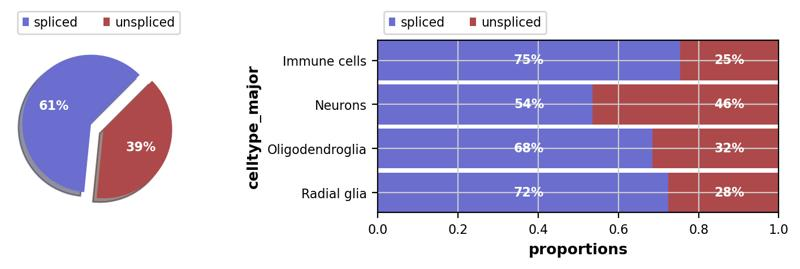

In [19]:
scv.pl.proportions(rhom_sub, groupby='celltype_major')

#### Normalize, find variable genes, run PCA

In [20]:
scv.pp.filter_and_normalize(rhom_sub, log=True)

Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [21]:
sc.pp.highly_variable_genes(rhom_sub, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


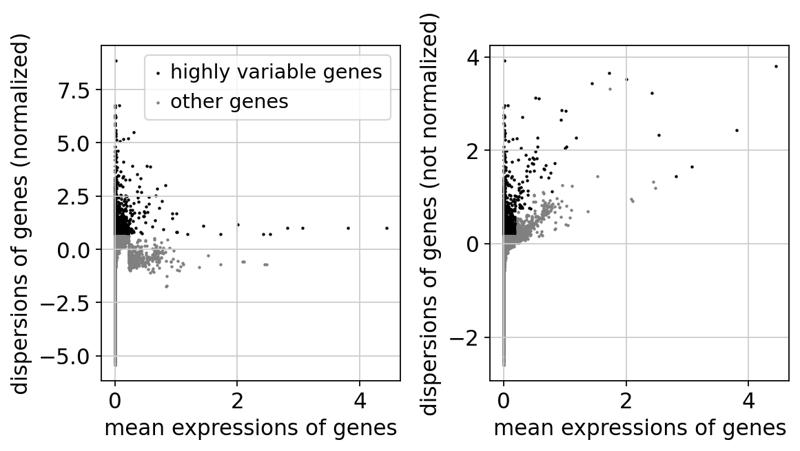

In [22]:
sc.pl.highly_variable_genes(rhom_sub)

In [23]:
sc.tl.pca(rhom_sub)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


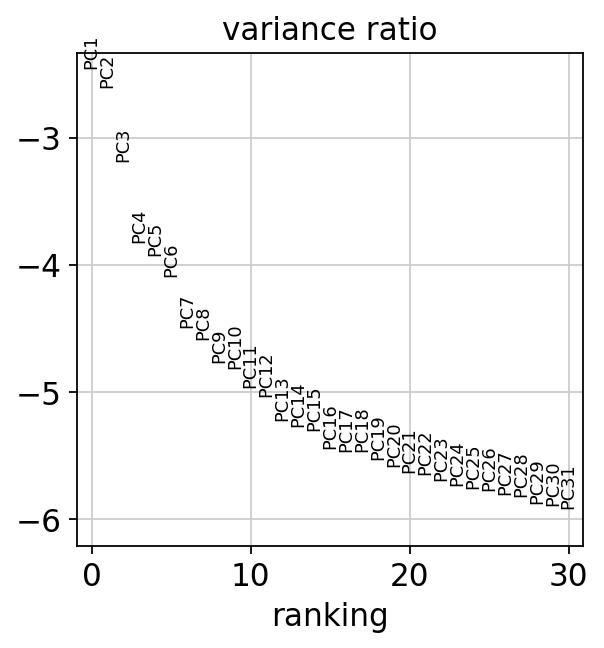

In [24]:
sc.pl.pca_variance_ratio(rhom_sub, log=True)

In [25]:
# if n_pcs=None, n_neighbors=None arguments are used will use already existing embedding, in this case based on bbknn
scv.pp.moments(rhom_sub, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [26]:
sc.tl.umap(rhom_sub)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


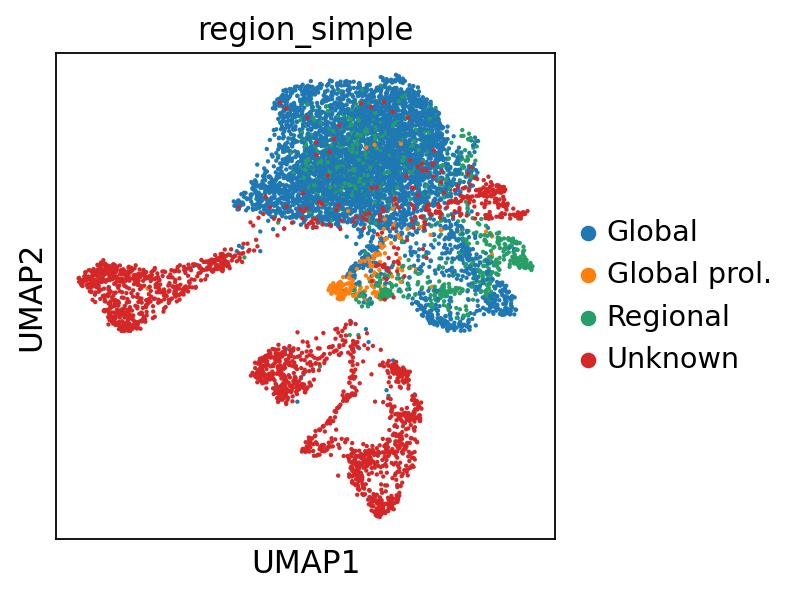

In [27]:
sc.pl.umap(rhom_sub, color=['region_simple'])

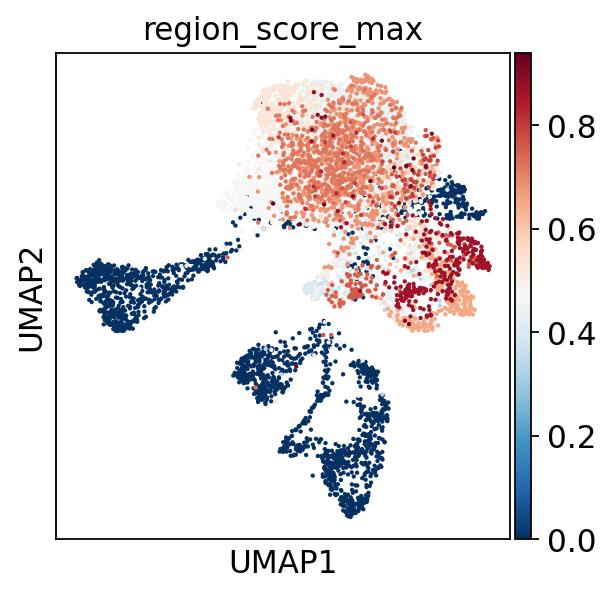

In [28]:
sc.pl.umap(rhom_sub, color=['region_score_max'])

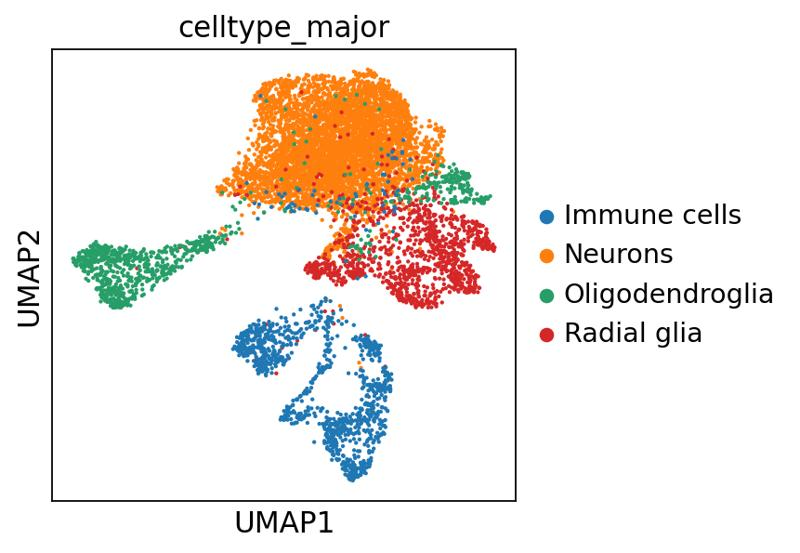

In [29]:
sc.pl.umap(rhom_sub, color=['celltype_major'])

#### Leiden clustering 

In [30]:
sc.tl.leiden(rhom_sub, resolution=1.5)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


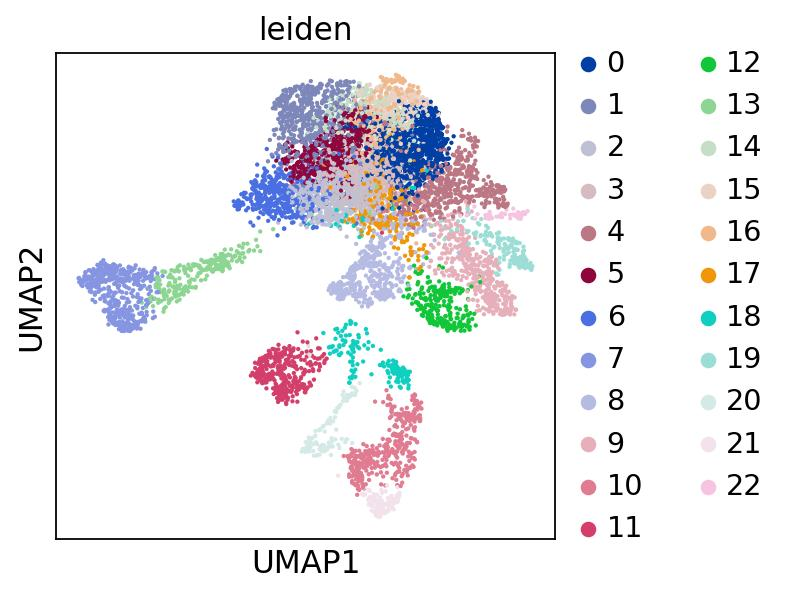

In [31]:
sc.pl.umap(rhom_sub, color=['leiden'])

#### Cell cycle score

In [32]:
G2M_phase_genes = pd.read_csv("/local/users/nfresma/zebrafish_G2Mphase_genes.csv")
S_phase_genes = pd.read_csv("/local/users/nfresma/zebrafish_Sphase_genes.csv")

In [33]:
cell_cycle_genes = (G2M_phase_genes['x'].append(S_phase_genes['x']))

In [34]:
sc.tl.score_genes(rhom_sub, cell_cycle_genes, score_name="cell_cycle_score")

computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    795 total control genes are used. (0:00:00)


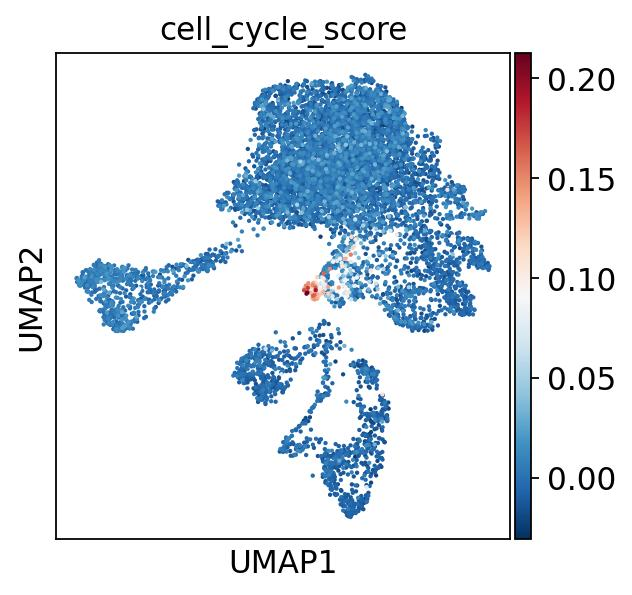

In [35]:
sc.pl.umap(rhom_sub, color='cell_cycle_score')

In [36]:
sc.tl.score_genes(rhom_sub, G2M_phase_genes['x'], score_name="G2M_phase") #average expression of set of genes subtracted with average expression of reference set of genes (randomly samppled from gene_pool)

computing score 'G2M_phase'
    finished: added
    'G2M_phase', score of gene set (adata.obs).
    747 total control genes are used. (0:00:00)


In [37]:
sc.tl.score_genes(rhom_sub, S_phase_genes['x'], score_name="S_phase") #average expression of set of genes subtracted with average expression of reference set of genes (randomly samppled from gene_pool)

computing score 'S_phase'
    finished: added
    'S_phase', score of gene set (adata.obs).
    647 total control genes are used. (0:00:00)


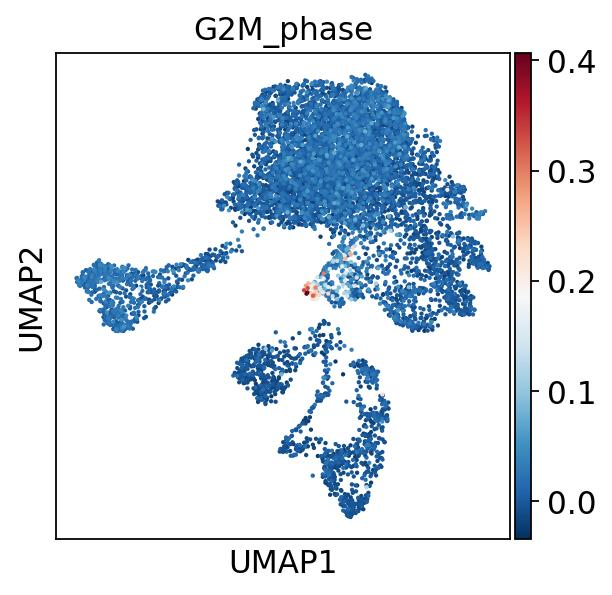

In [38]:
sc.pl.umap(rhom_sub, color='G2M_phase') #, save="G2M_phase")

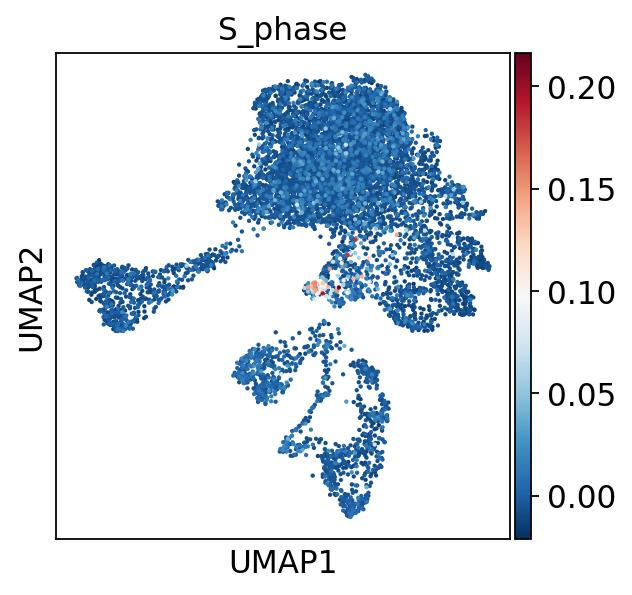

In [39]:
sc.pl.umap(rhom_sub, color='S_phase')#, save="_S_phase")

### ScVelo analysis

In [40]:
scv.tl.velocity(rhom_sub, mode='stochastic')
scv.tl.velocity_graph(rhom_sub) 

computing velocities
    finished (0:00:59) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/112 cores)


  0%|          | 0/7901 [00:00<?, ?cells/s]

    finished (0:00:25) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [41]:
rhom_sub.var['velocity_genes'].sum()

655

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


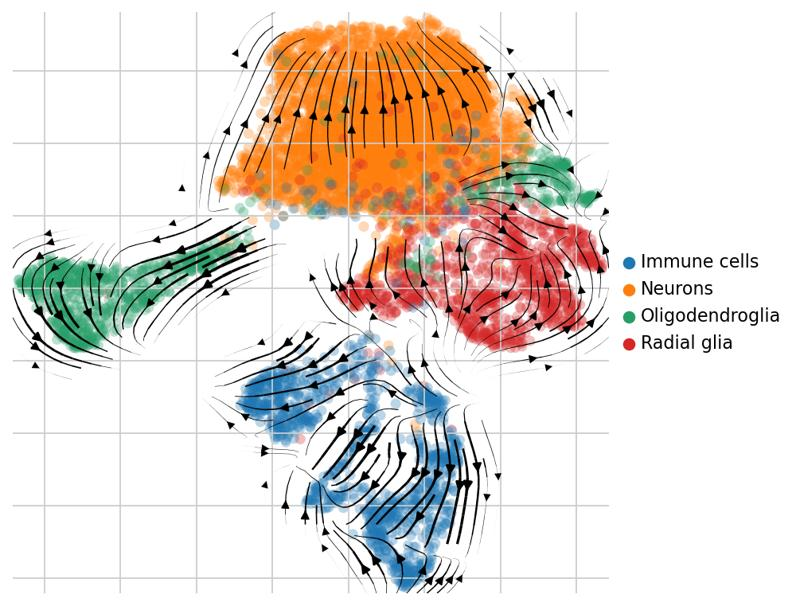

In [42]:
scv.pl.velocity_embedding_stream(rhom_sub, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['celltype_major'], legend_loc='right margin', figsize=[6,6]) #stochastic

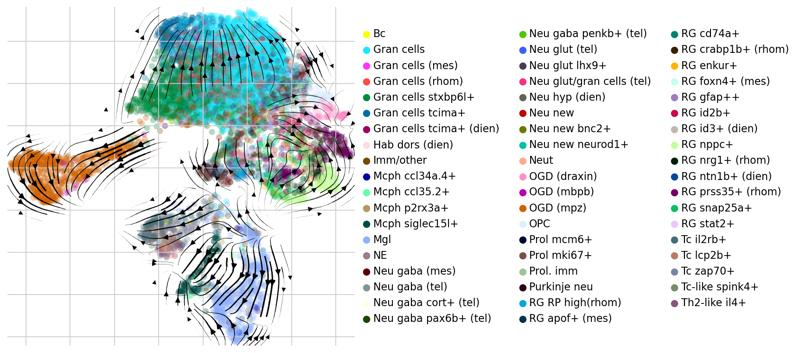

In [43]:
scv.pl.velocity_embedding_stream(rhom_sub, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['celltype_detailed_short'], legend_loc='right margin', figsize=[6,6]) #stochastic

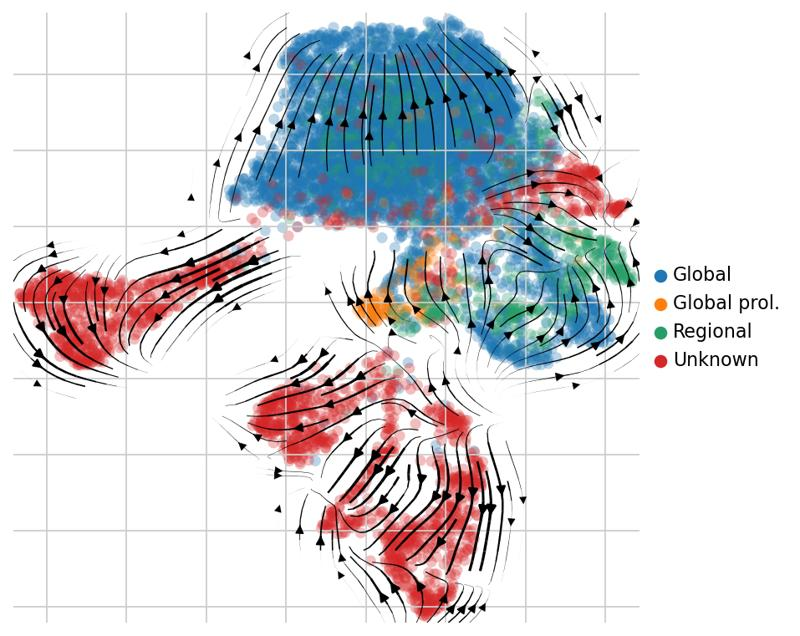

In [44]:
scv.pl.velocity_embedding_stream(rhom_sub, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['region_simple'], legend_loc='right margin', figsize=[6,6]) #stochastic

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


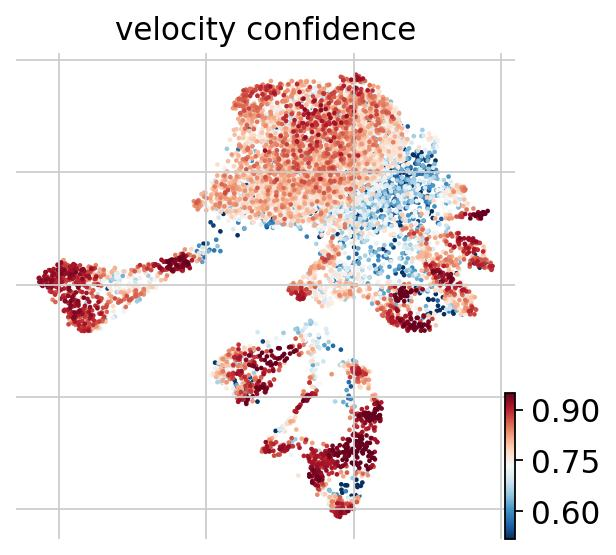

In [45]:
scv.tl.velocity_confidence(rhom_sub)
scv.pl.scatter(rhom_sub, color='velocity_confidence', perc=[2,98])

## Radial glia and neurons

Load the unprocessed dataset, then subset for only radial glia and neurons and repeat scVelo analysis.  
Also, subset based on the Keep_in_final column (where I flagged some small clusters of putative doublets for exclusion).  

In [38]:
# read in
rhom_rg_neu = sc.read_h5ad(filename="rhom_sub_prepr")

In [39]:
rhom_rg_neu.obs['celltype_major'].cat.categories

Index(['Endothelial cells', 'Ependymal cells', 'Epithelial cells',
       'Erythrocytes', 'Immune cells', 'Neurons', 'Oligodendroglia',
       'Radial glia'],
      dtype='object')

In [40]:
celltypes_kept = ['Neurons', 'Radial glia']

In [41]:
rhom_rg_neu = rhom_rg_neu[rhom_rg_neu.obs['celltype_major'].isin(celltypes_kept)]

In [42]:
rhom_rg_neu.obs['celltype_major'].cat.categories

Index(['Neurons', 'Radial glia'], dtype='object')

In [43]:
rhom_rg_neu.obs['keep_in_final'].cat.categories

Index(['False', 'True'], dtype='object')

In [44]:
kept_in_final = ['True']

In [45]:
rhom_rg_neu = rhom_rg_neu[rhom_rg_neu.obs['keep_in_final'].isin(kept_in_final)]

In [46]:
rhom_rg_neu.obs['keep_in_final'].cat.categories

Index(['True'], dtype='object')

In [47]:
rhom_rg_neu

View of AnnData object with n_obs × n_vars = 5917 × 32520
    obs: 'orig_barcode', 'fixation', 'celltype_major', 'celltype_detailed', 'celltype_detailed_short', 'keep_in_final', 'region_simple', 'region_detailed', 'region_score_max', 'region_score_max_name', 'region_score_tel', 'region_score_dien', 'region_score_mes', 'region_score_rhom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

### Preprocessing for scVelo  

Perform standard preprocessing steps to get the UMAP embedding and clustering.  

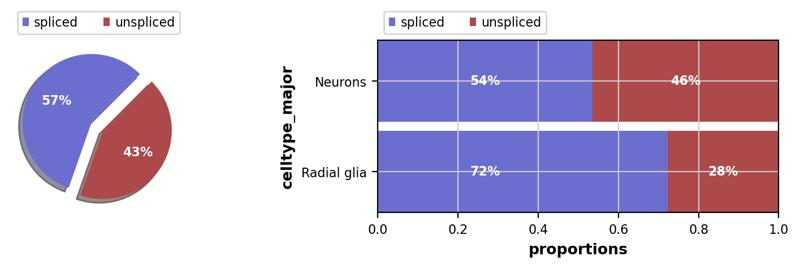

In [48]:
scv.pl.proportions(rhom_rg_neu, groupby = 'celltype_major')

#### Normalize, find variable genes, run PCA

In [49]:
scv.pp.filter_and_normalize(rhom_rg_neu, log=True)

Trying to set attribute `.obs` of view, copying.


Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [50]:
sc.pp.highly_variable_genes(rhom_rg_neu, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


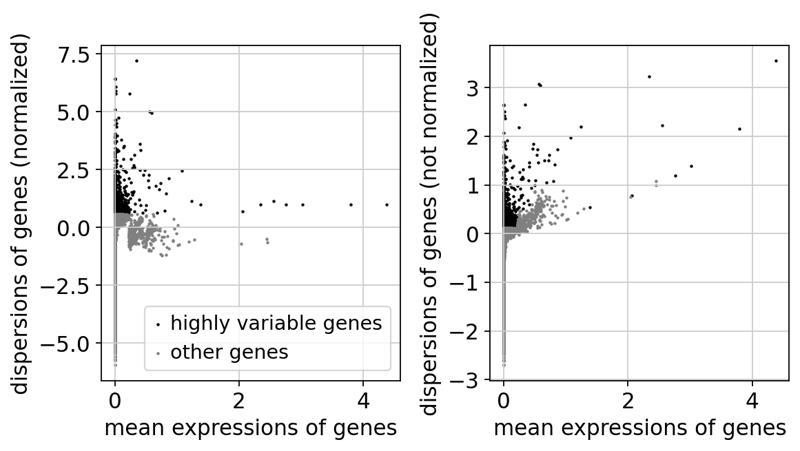

In [51]:
sc.pl.highly_variable_genes(rhom_rg_neu)

In [52]:
sc.tl.pca(rhom_rg_neu)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


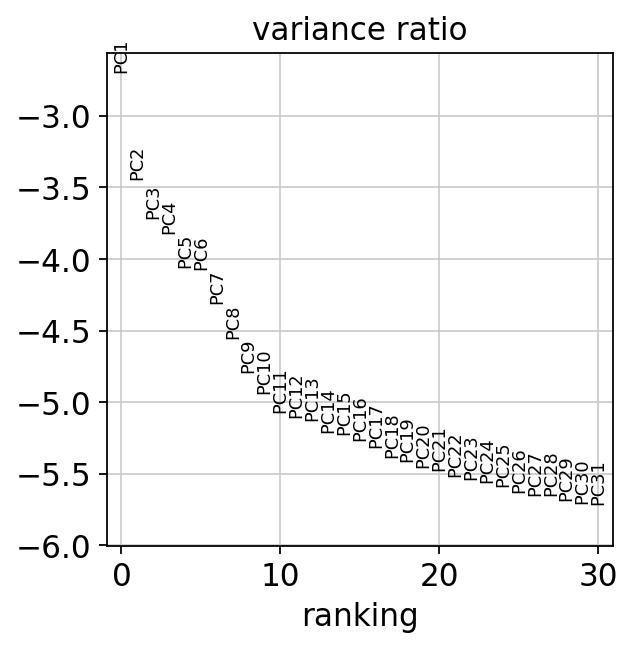

In [53]:
sc.pl.pca_variance_ratio(rhom_rg_neu, log=True)

In [54]:
# if n_pcs=None, n_neighbors=None arguments are used will use already existing embedding, in this case based on bbknn
scv.pp.moments(rhom_rg_neu, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [55]:
sc.tl.umap(rhom_rg_neu)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


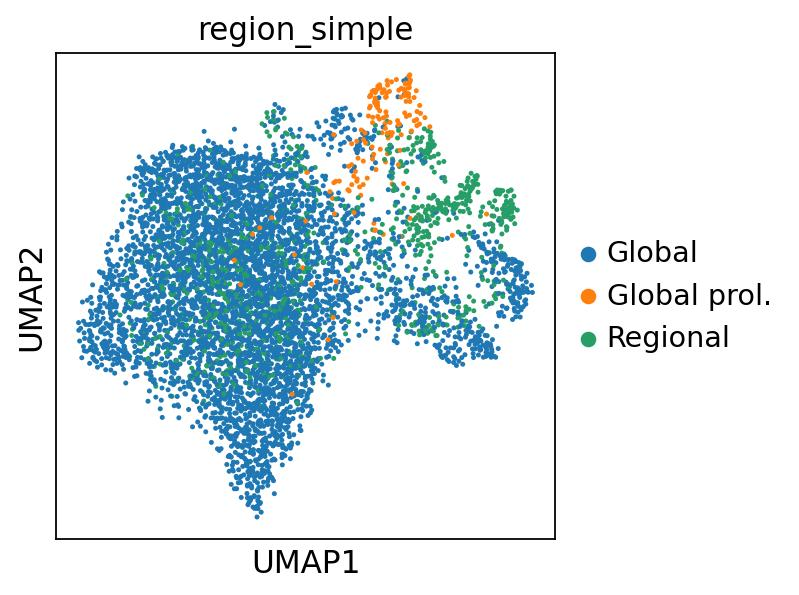

In [56]:
sc.pl.umap(rhom_rg_neu, color=['region_simple'])

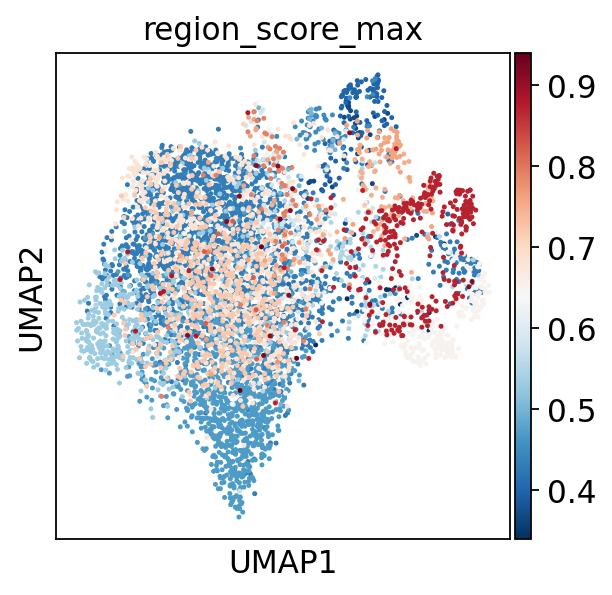

In [57]:
sc.pl.umap(rhom_rg_neu, color=['region_score_max'])

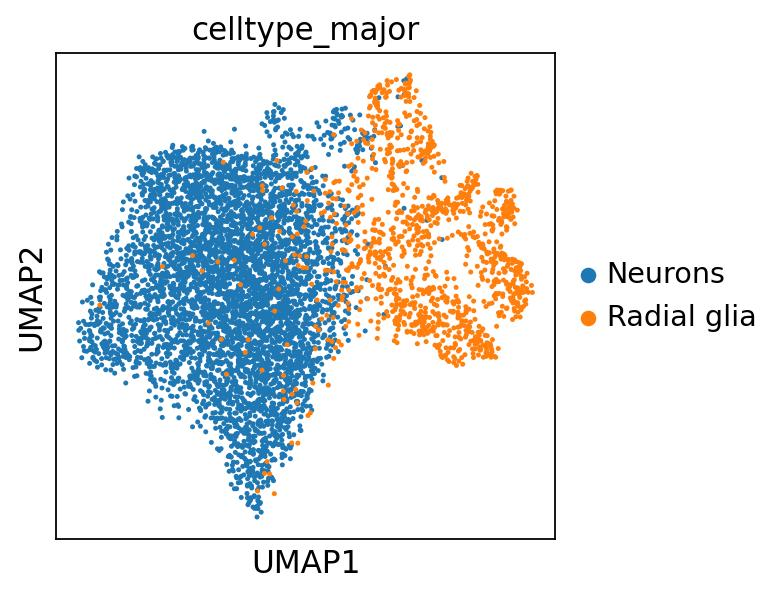

In [58]:
sc.pl.umap(rhom_rg_neu, color=['celltype_major'])

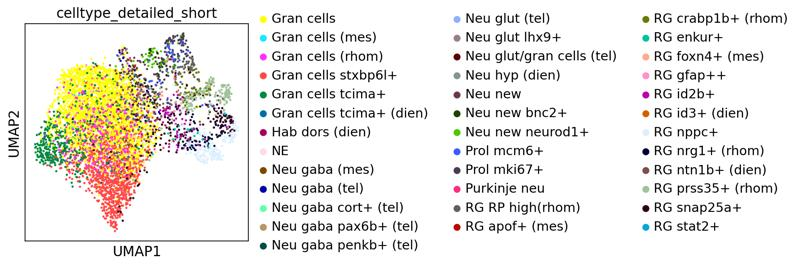

In [59]:
sc.pl.umap(rhom_rg_neu, color='celltype_detailed_short')

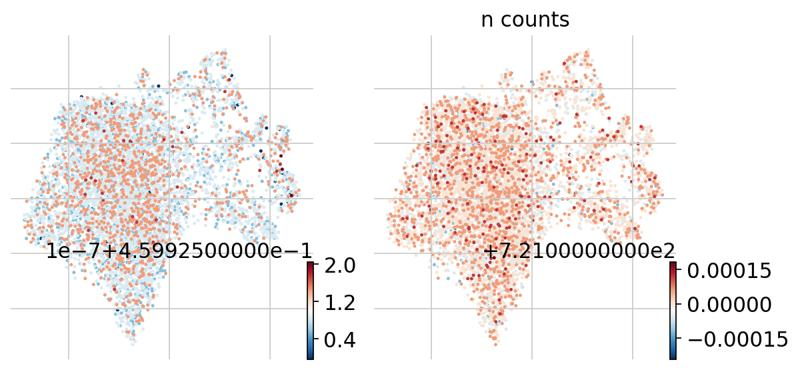

In [60]:
counts_s = scv.utils.sum_var(rhom_rg_neu.layers['spliced'])
counts_u = scv.utils.sum_var(rhom_rg_neu.layers['unspliced'])
fractions_u = counts_u / (counts_s + counts_u)
scv.pl.scatter(rhom_rg_neu, color=[fractions_u, 'n_counts'])

#### Leiden clustering 

In [61]:
sc.tl.leiden(rhom_rg_neu, resolution=1.5)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


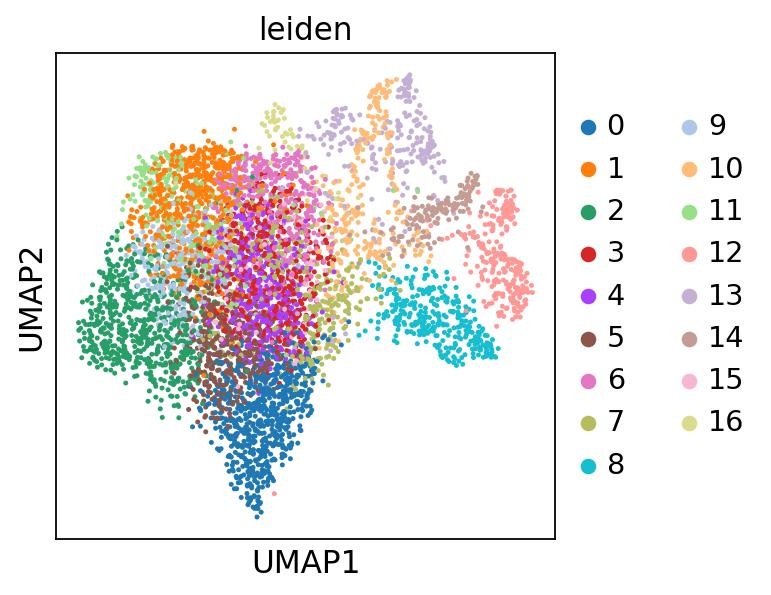

In [62]:
sc.pl.umap(rhom_rg_neu, color=['leiden'])

#### Cell cycle score

In [63]:
G2M_phase_genes = pd.read_csv("/local/users/nfresma/zebrafish_G2Mphase_genes.csv")
S_phase_genes = pd.read_csv("/local/users/nfresma/zebrafish_Sphase_genes.csv")

In [64]:
cell_cycle_genes = (G2M_phase_genes['x'].append(S_phase_genes['x']))

In [65]:
cell_cycle_genes

0       anln
1     anp32e
2      aurka
3     birc5a
4     birc5b
       ...  
36     uhrf1
37      unga
38      ungb
39      usp1
40     wdr76
Name: x, Length: 89, dtype: object

In [66]:
sc.tl.score_genes(rhom_rg_neu, cell_cycle_genes, score_name="cell_cycle_score")

computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    748 total control genes are used. (0:00:00)


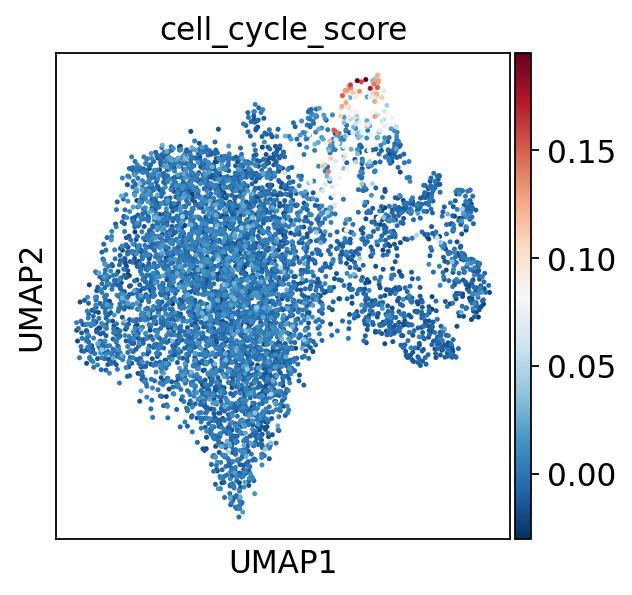

In [67]:
sc.pl.umap(rhom_rg_neu, color='cell_cycle_score')

In [68]:
sc.tl.score_genes(rhom_rg_neu, G2M_phase_genes['x'], score_name="G2M_phase") #average expression of set of genes subtracted with average expression of reference set of genes (randomly samppled from gene_pool)

computing score 'G2M_phase'
    finished: added
    'G2M_phase', score of gene set (adata.obs).
    699 total control genes are used. (0:00:00)


In [69]:
sc.tl.score_genes(rhom_rg_neu, S_phase_genes['x'], score_name="S_phase") #average expression of set of genes subtracted with average expression of reference set of genes (randomly samppled from gene_pool)

computing score 'S_phase'
    finished: added
    'S_phase', score of gene set (adata.obs).
    598 total control genes are used. (0:00:00)


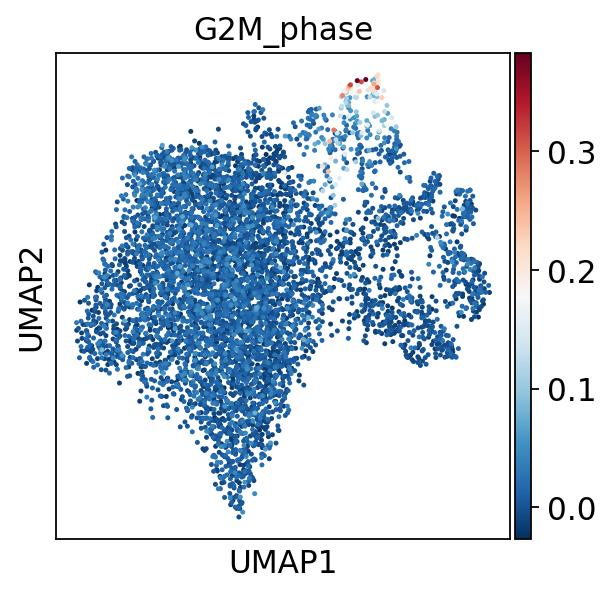

In [70]:
sc.pl.umap(rhom_rg_neu, color='G2M_phase') #, save="G2M_phase")

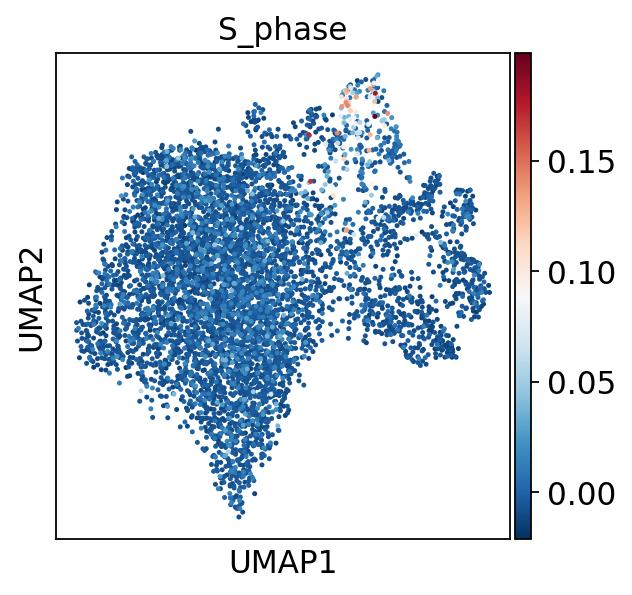

In [71]:
sc.pl.umap(rhom_rg_neu, color='S_phase')#, save="_S_phase")

#### Notch activation score

In [72]:
notch_downstream_genes = ['her4.2', 'her4.4', 'her15.1', 'her6', 'her15.2', 'her12', #orthologues to hes1/5
                                                       'hey1', 'hey2' #orthologues to hey
                         ]

In [73]:
notch_downstream_genes

['her4.2', 'her4.4', 'her15.1', 'her6', 'her15.2', 'her12', 'hey1', 'hey2']

In [74]:
sc.tl.score_genes(rhom_rg_neu, notch_downstream_genes, score_name="notch_score")

computing score 'notch_score'
    finished: added
    'notch_score', score of gene set (adata.obs).
    299 total control genes are used. (0:00:00)


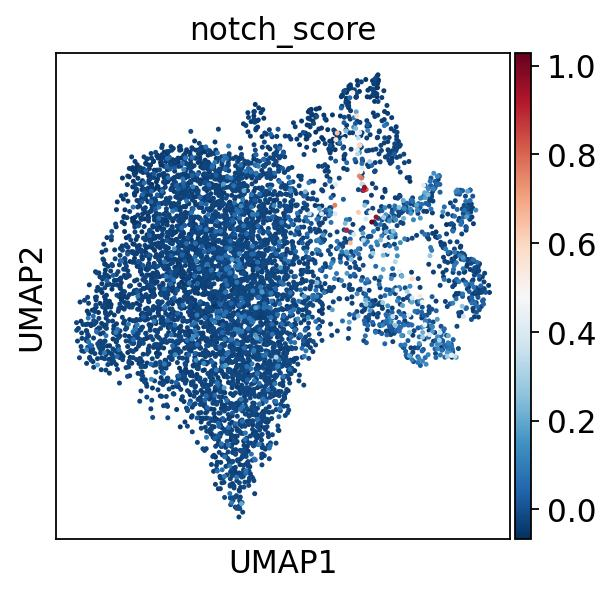

In [75]:
sc.pl.umap(rhom_rg_neu, color='notch_score')

### ScVelo analysis

In [76]:
scv.tl.velocity(rhom_rg_neu, mode='stochastic')
scv.tl.velocity_graph(rhom_rg_neu) 

computing velocities
    finished (0:00:40) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5917 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [77]:
rhom_rg_neu.var['velocity_genes'].sum()

322

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


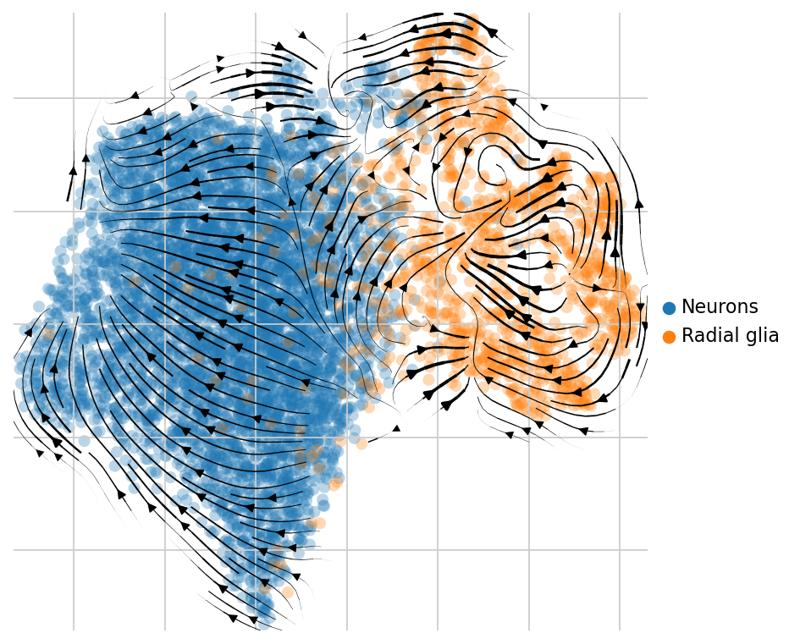

In [78]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['celltype_major'], legend_loc='right margin', figsize=[6,6]) #stochastic

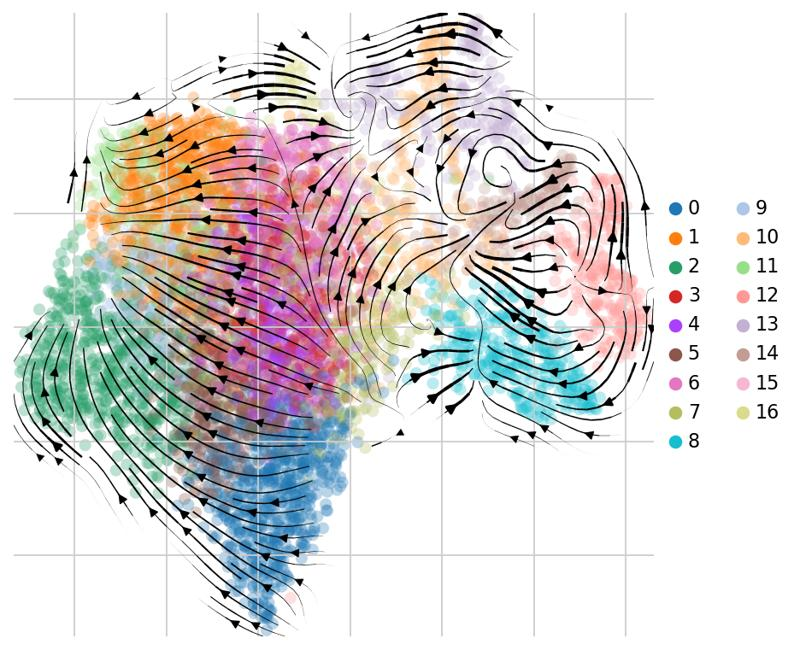

In [79]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['leiden'], legend_loc='right margin', figsize=[6,6]) #stochastic

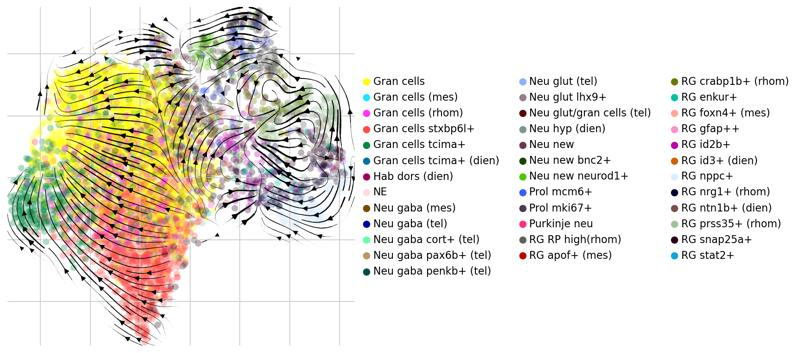

In [80]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['celltype_detailed_short'], legend_loc='right margin', figsize=[6,6]) #stochastic

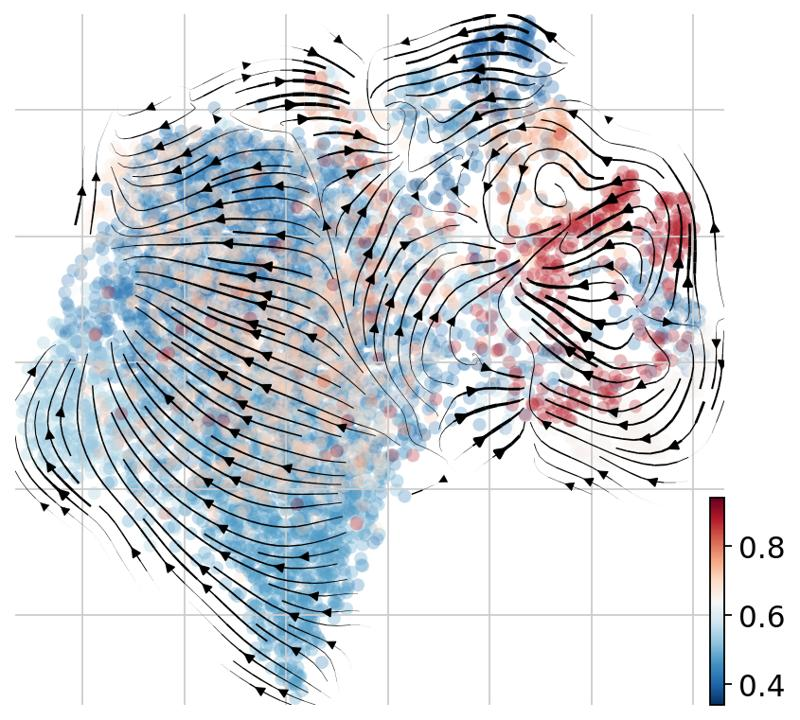

In [81]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['region_score_max'], legend_loc='right margin', figsize=[6,6]) #stochastic

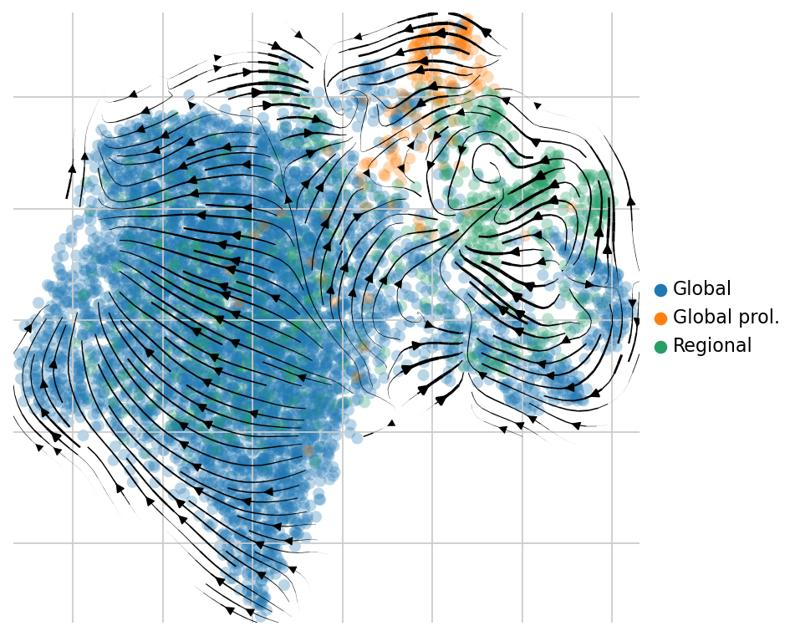

In [82]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=10, title='', smooth=.8, min_mass=0, 
                                 color=['region_simple'], legend_loc='right margin', figsize=[6,6]) #stochastic

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


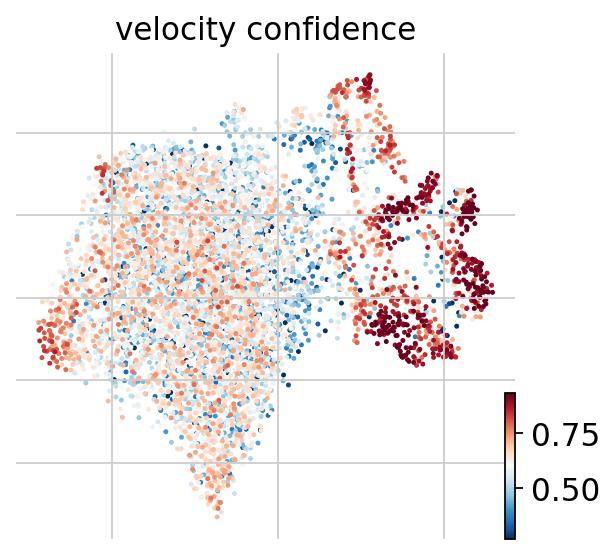

In [83]:
scv.tl.velocity_confidence(rhom_rg_neu)
scv.pl.scatter(rhom_rg_neu, color='velocity_confidence', perc=[2,98])

#### Save RG/neu subset to disk after processing

Save after running scVelo for easier pick up for figure making.

In [84]:
rhom_rg_neu.write(filename="rhom_rg_neu_scv", compression='gzip')

In [2]:
# read in
rhom_rg_neu = sc.read_h5ad(filename="rhom_rg_neu_scv")

In [3]:
rhom_rg_neu

AnnData object with n_obs × n_vars = 5917 × 32520
    obs: 'orig_barcode', 'fixation', 'celltype_major', 'celltype_detailed', 'celltype_detailed_short', 'keep_in_final', 'region_simple', 'region_detailed', 'region_score_max', 'region_score_max_name', 'region_score_tel', 'region_score_dien', 'region_score_mes', 'region_score_rhom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'leiden', 'cell_cycle_score', 'G2M_phase', 'S_phase', 'notch_score', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'celltype_detailed_short_colors', 'celltype_major_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'region_simple_colors', 'umap', 'velocity_graph', 'velocity_graph_neg', 'veloc

### Export figures

In [4]:
# try range of parameters to improve figure look
# important: frameon = False removes the background grid !!
scv.set_figure_params(style='scvelo', dpi=100, dpi_save=150, frameon=False, 
                          vector_friendly=False, transparent=True, fontsize=12, 
                          figsize=None, color_map=None, facecolor=None, 
                          format='pdf', ipython_format='png2x')

In [88]:
col_celltype_major = {'Neurons' : '#80b1d3', 
                       'Radial glia' : '#bebada'}

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_mct.png


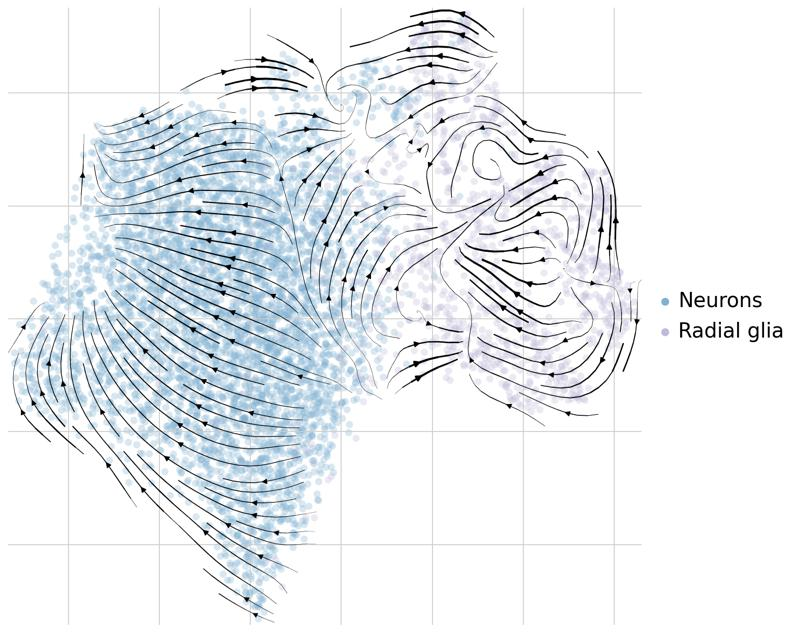

In [93]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['celltype_major'], palette=col_celltype_major, legend_loc='right margin', figsize=[10,10], save='rhom_embstr_mct') #stochastic

In [4]:
# select darker version of colors used in Fig2 (from pallette Paired 12-class)
col_region_simple = {'Global' : '#1f78b4', 
                    'Global prol.' : '#33a02c',
                    'Regional' : '#ff7f00'}

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_rgp.png


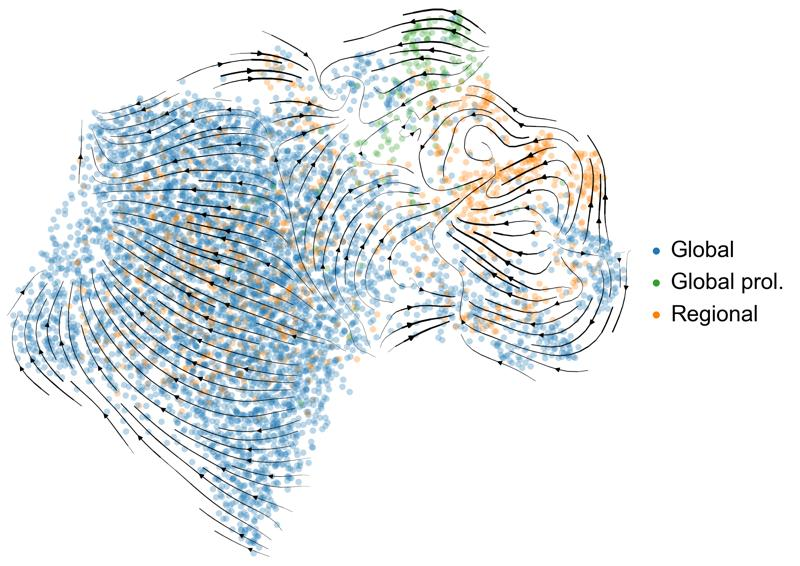

In [5]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=22, title='', smooth=.8, min_mass=3, 
                                 color=['region_simple'], palette=col_region_simple,
                                 legend_loc='right margin', figsize=[11,10], save='rhom_embstr_rgp') #stochastic

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_rgp.png


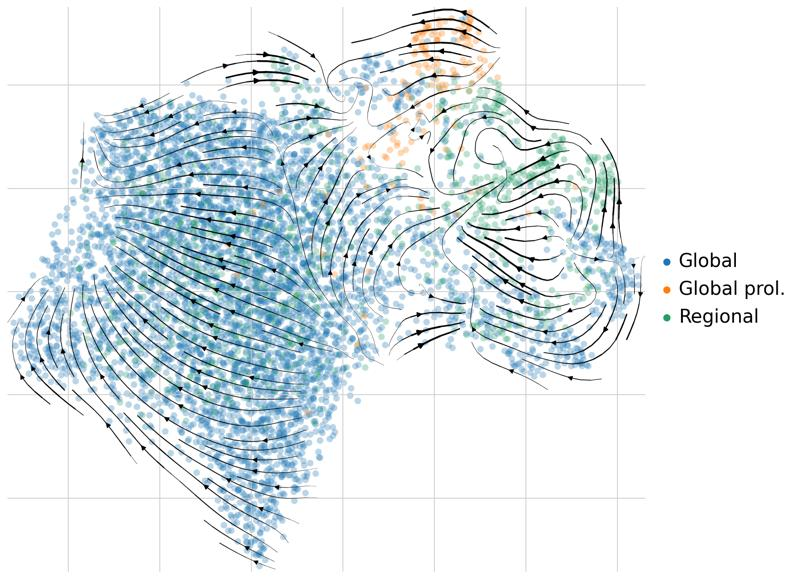

In [3]:
# old version - default colors
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['region_simple'], legend_loc='right margin', figsize=[11,10], save='rhom_embstr_rgp') #stochastic

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_rsmax.png


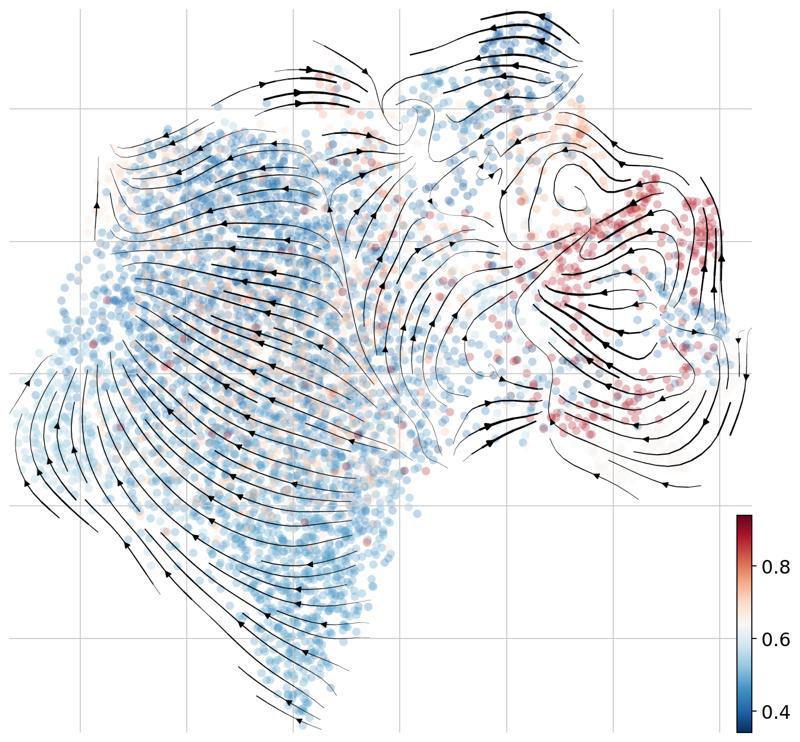

In [95]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['region_score_max'], legend_loc='right margin', figsize=[10,10], save='rhom_embstr_rsmax') #stochastic

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_rsrhom.png


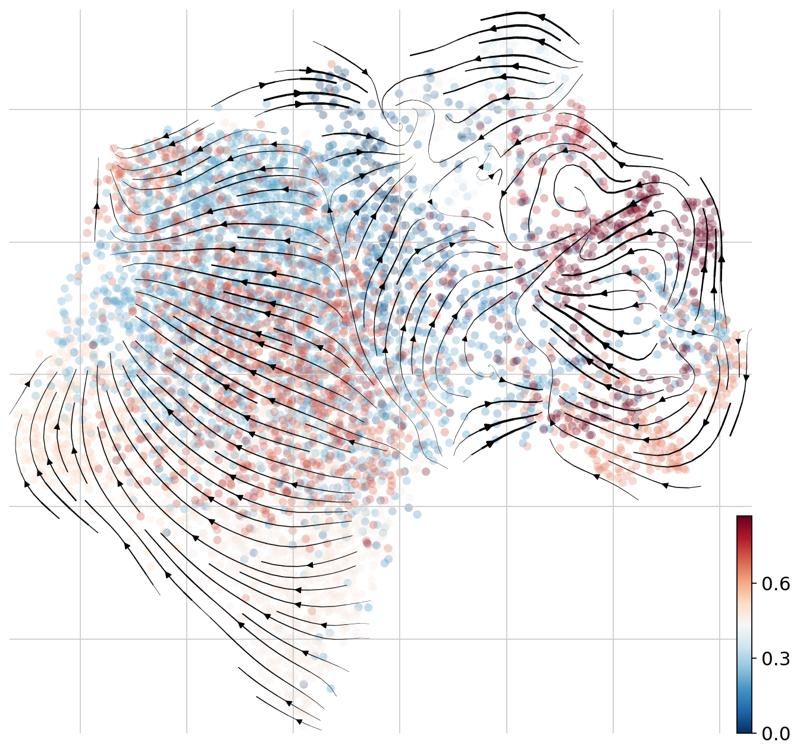

In [96]:
#scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
#                                 color=['region_score_rhom'], legend_loc='right margin', figsize=[10,10], save='rhom_embstr_rsrhom') #stochastic

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_rhom_embstr_rsrhom.png


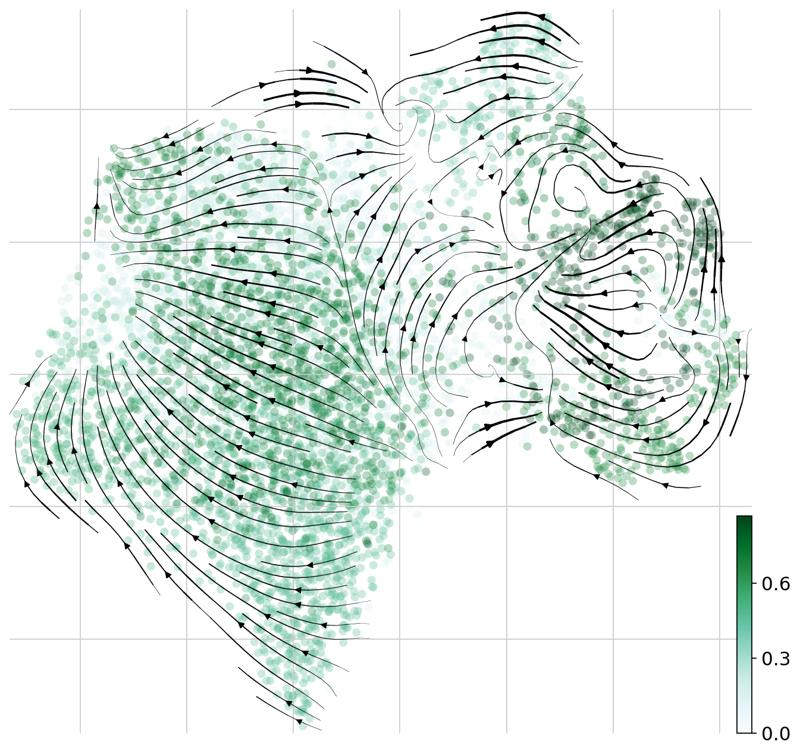

In [3]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['region_score_rhom'], color_map='BuGn', legend_loc='right margin', figsize=[10,10], save='rhom_embstr_rsrhom') #stochastic

In [3]:
#make custom colormap

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

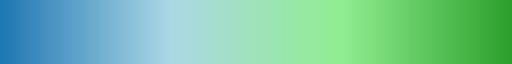

In [4]:
glo_reg_list=["tab:blue", "lightblue", "lightgreen", "tab:green"]
glo_reg_pal=LinearSegmentedColormap.from_list('GloRegCmap', colors=glo_reg_list, N=256)
glo_reg_pal

saving figure to file ./figures/scvelo_rhom_embstr_rsrhom.png


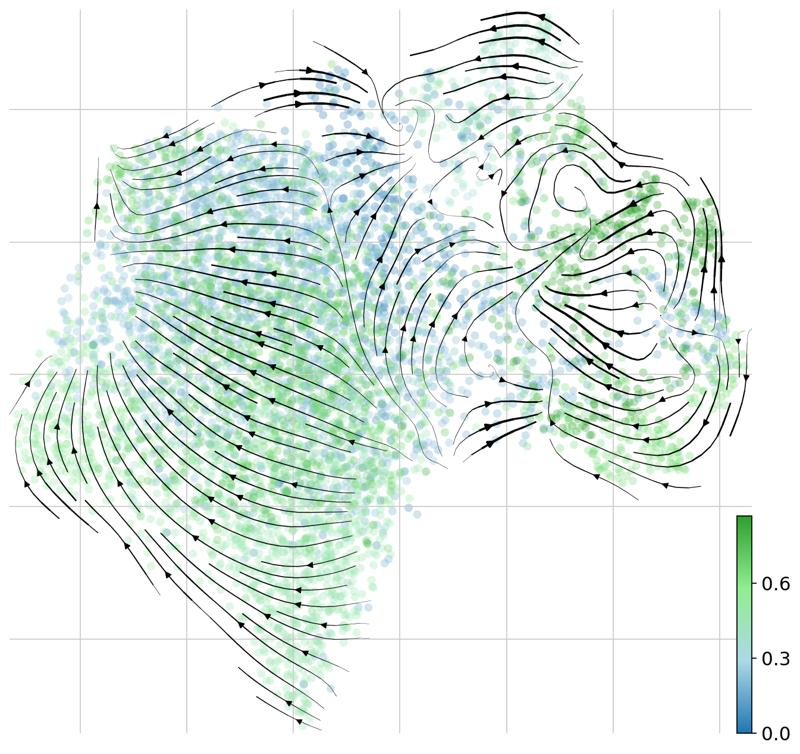

In [5]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['region_score_rhom'], color_map=glo_reg_pal, legend_loc='right margin', figsize=[10,10], save='rhom_embstr_rsrhom.png') #stochastic

Alternative pallette - regional in orange instead of green? (for clearer separation)  

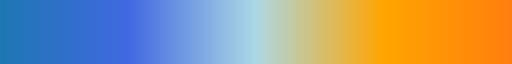

In [19]:
glo_reg_list=["tab:blue", "royalblue", "lightblue", "orange", "tab:orange"]
glo_reg_pal=LinearSegmentedColormap.from_list('GloRegCmap', colors=glo_reg_list, N=256)
glo_reg_pal

saving figure to file ./figures/scvelo_rhom_embstr_rsrhom_blor.png


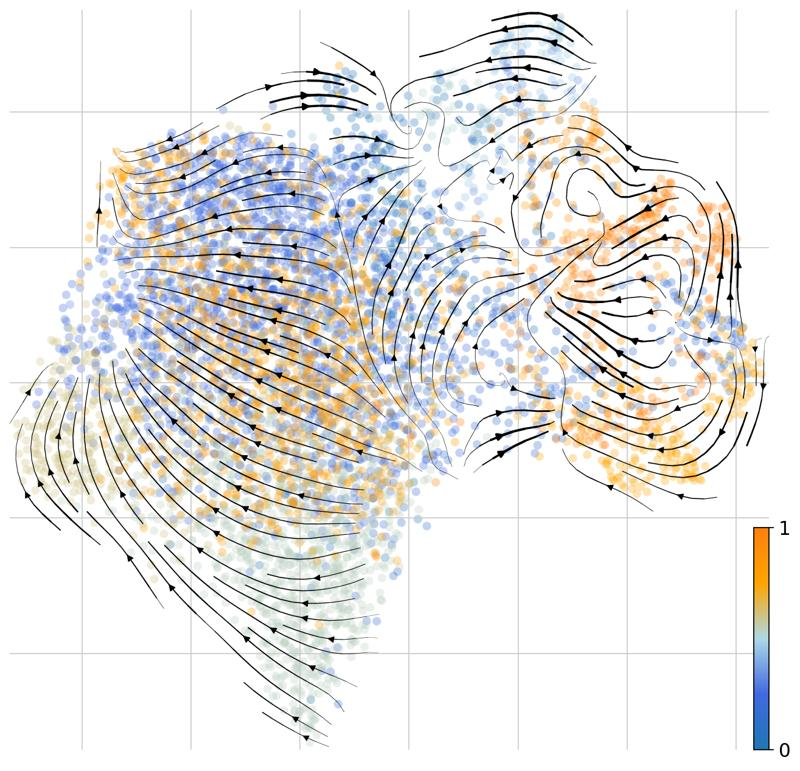

In [20]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['region_score_rhom'], color_map=glo_reg_pal, rescale_color=[0,1],
                                 legend_loc='right margin', figsize=[10,10],
                                save='rhom_embstr_rsrhom_blor.png')
#, save='rhom_embstr_rsrhom.png') #stochastic

saving figure to file ./figures/scvelo_rhom_embstr_ccsc.png


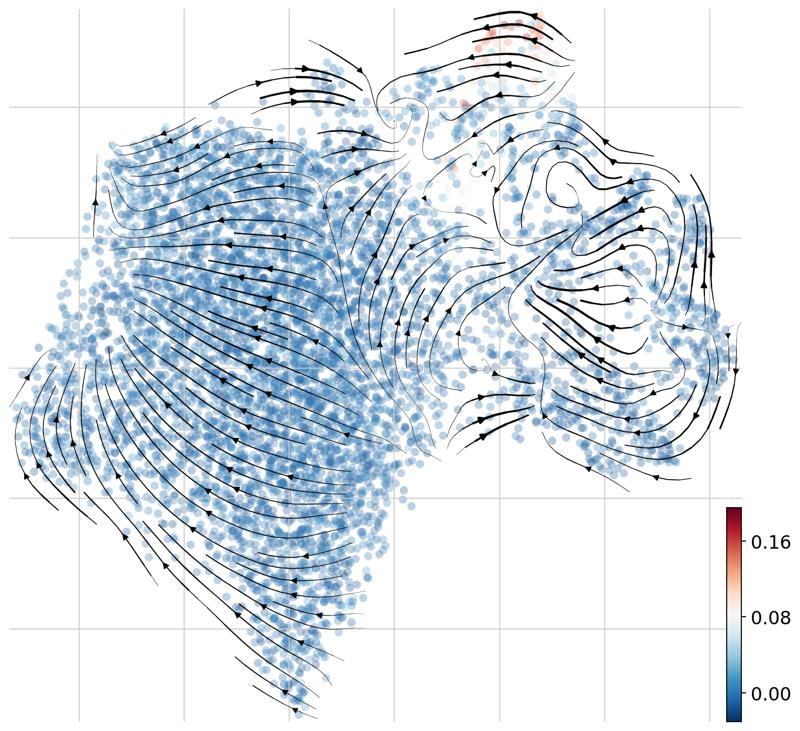

In [16]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['cell_cycle_score'], legend_loc='right margin', figsize=[10,10], save='rhom_embstr_ccsc.png') #stochastic

saving figure to file ./figures/scvelo_rhom_embstr_nsc.png


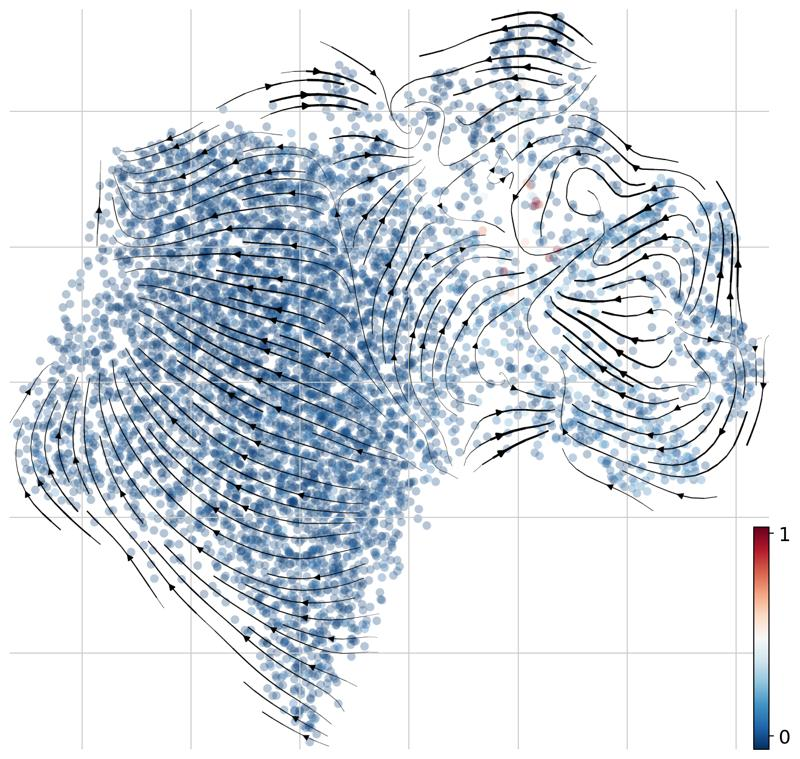

In [17]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, title='', smooth=.8, min_mass=3, 
                                 color=['notch_score'], legend_loc='right margin', figsize=[10,10], save='rhom_embstr_nsc.png') #stochastic

#### Detailed celltype - rearrange metadata

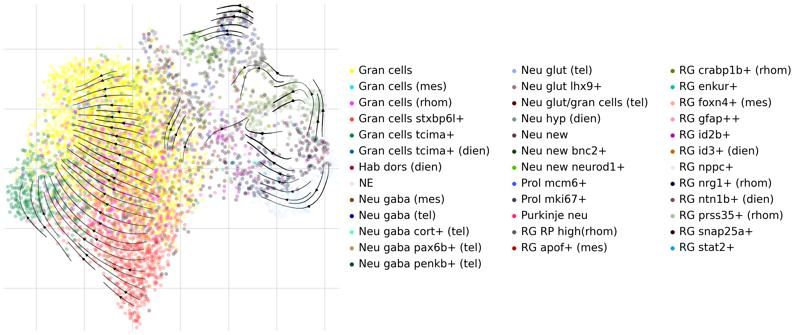

In [85]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, 
                                 title='', smooth=.8, min_mass=4, 
                                 color=['celltype_detailed_short'],
                                 legend_loc='right margin', 
                                 figsize=[10,10])#, save='rhom_embstr_dct' #stochastic

For plotting detailed cell types, a problem that occurs is too much information - I want to highlight only a few most critical cell types and classify everything else as "Other". The easiest way to do this is with a new simplified metadata column based on the detailed cell type annotation.  

In [88]:
rhom_rg_neu.obs.celltype_detailed.cat.categories

Index(['Granule cells', 'Granule cells (mes)', 'Granule cells (rhom)',
       'Granule cells stxbp6l+ ', 'Granule cells tcima+',
       'Granule cells tcima+ (dien)', 'Habenula dorsal (dien)',
       'Neuroepithelial cells', 'Neurons gabaergic (mes)',
       'Neurons gabaergic (tel)', 'Neurons gabaergic cort+ (tel)',
       'Neurons gabaergic pax6b+ (tel)', 'Neurons gabaergic penkb+ (tel)',
       'Neurons glutamatargic (tel)', 'Neurons glutamatergic lhx9+',
       'Neurons glutamatergic/granule cells (tel)',
       'Neurons hypothalamus (dien)', 'Neurons newborn',
       'Neurons newborn bnc2+', 'Neurons newborn neurod1+',
       'Proliferating cells mcm6+', 'Proliferating cells mki67+',
       'Purkinje neurons', 'Radial glia RP high(rhom)',
       'Radial glia apof+ (mes)', 'Radial glia crabp1b+ (rhom)',
       'Radial glia enkur+', 'Radial glia foxn4+ (mes)', 'Radial glia gfap++',
       'Radial glia id2b+', 'Radial glia id3+ (dien)', 'Radial glia nppc+',
       'Radial glia nrg1+ 

In [89]:
rhom_rg_neu.obs.celltype_detailed.value_counts()

Granule cells                                2373
Granule cells stxbp6l+                       1053
Granule cells tcima+                          479
Granule cells (rhom)                          442
Radial glia nppc+                             234
Radial glia prss35+ (rhom)                    185
Radial glia snap25a+                          179
Proliferating cells mki67+                    112
Neurons newborn                                99
Radial glia id2b+                              92
Radial glia nrg1+ (rhom)                       89
Neurons glutamatergic lhx9+                    78
Radial glia crabp1b+ (rhom)                    70
Radial glia RP high(rhom)                      59
Neurons newborn neurod1+                       59
Neurons gabaergic (mes)                        54
Neurons newborn bnc2+                          48
Proliferating cells mcm6+                      43
Purkinje neurons                               35
Neurons gabaergic (tel)                        27


##### Version 1 - highlight same cell types as in tel

In [90]:
celltype_detailed_selective = rhom_rg_neu.obs.celltype_detailed

In [91]:
type(celltype_detailed_selective)

pandas.core.series.Series

In [92]:
celltype_detailed_selective

B18.R_AAACCCAAGGAGAGGC-1        Granule cells stxbp6l+ 
B18.R_AAACCCACAAGCACAG-1    Neurons glutamatargic (tel)
B18.R_AAACCCACAGGGAGAG-1                  Granule cells
B18.R_AAACGAAAGTTGCCTA-1                  Granule cells
B18.R_AAACGAACAATTGAGA-1           Granule cells (rhom)
                                       ...             
B18.R_TTTCGATTCGCCAATA-1              Radial glia nppc+
B18.R_TTTGATCCACTCTGCT-1      Proliferating cells mcm6+
B18.R_TTTGGAGTCAATCCGA-1     Radial glia prss35+ (rhom)
B18.R_TTTGGAGTCTACTTCA-1     Radial glia prss35+ (rhom)
B18.R_TTTGTTGCAGCGCGTT-1     Radial glia prss35+ (rhom)
Name: celltype_detailed, Length: 5917, dtype: category
Categories (37, object): ['Granule cells', 'Granule cells (mes)', 'Granule cells (rhom)', 'Granule cells stxbp6l+ ', ..., 'Radial glia ntn1b+ (dien)', 'Radial glia prss35+ (rhom)', 'Radial glia snap25a+', 'Radial glia stat2+']

In [93]:
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells (mes)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells (rhom)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells stxbp6l+ ', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells tcima+', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Granule cells tcima+ (dien)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Habenula dorsal (dien)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Habenula ventral (dien)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neuroepithelial cells', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons gabaergic (mes)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons gabaergic (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons gabaergic cort+ (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons gabaergic pax6b+ (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons gabaergic penkb+ (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons glutamatargic (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons glutamatergic lhx9+', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons glutamatergic/granule cells (tel)', 'Neurons (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons hypothalamus (dien)', 'Neurons (other)')

celltype_detailed_selective = celltype_detailed_selective.replace('Neurons newborn bnc2+', 'Neurons newborn')
celltype_detailed_selective = celltype_detailed_selective.replace('Neurons newborn neurod1+', 'Neurons newborn')

celltype_detailed_selective = celltype_detailed_selective.replace('Proliferating cells mcm6+', 'Proliferating cells')
celltype_detailed_selective = celltype_detailed_selective.replace('Proliferating cells mki67+', 'Proliferating cells')

celltype_detailed_selective = celltype_detailed_selective.replace('Purkinje neurons', 'Neurons (other)')

celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia RP high(rhom)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia apof+ (mes)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia crabp1b+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia enkur+', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia foxn4+ (mes)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia id3+ (dien)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia nppc+', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia nrg1+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia ntn1b+ (dien)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia prss35+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia stat2+', 'Radial glia (other)')
celltype_detailed_selective = celltype_detailed_selective.replace('Radial glia stra6+ (mes)', 'Radial glia (other)')

In [94]:
celltype_detailed_selective

B18.R_AAACCCAAGGAGAGGC-1        Neurons (other)
B18.R_AAACCCACAAGCACAG-1        Neurons (other)
B18.R_AAACCCACAGGGAGAG-1        Neurons (other)
B18.R_AAACGAAAGTTGCCTA-1        Neurons (other)
B18.R_AAACGAACAATTGAGA-1        Neurons (other)
                                   ...         
B18.R_TTTCGATTCGCCAATA-1    Radial glia (other)
B18.R_TTTGATCCACTCTGCT-1    Proliferating cells
B18.R_TTTGGAGTCAATCCGA-1    Radial glia (other)
B18.R_TTTGGAGTCTACTTCA-1    Radial glia (other)
B18.R_TTTGTTGCAGCGCGTT-1    Radial glia (other)
Name: celltype_detailed, Length: 5917, dtype: category
Categories (7, object): ['Neurons (other)', 'Neurons newborn', 'Proliferating cells', 'Radial glia (other)', 'Radial glia gfap++', 'Radial glia id2b+', 'Radial glia snap25a+']

In [95]:
rhom_rg_neu.obs['celltype_detailed_selective'] = pd.Categorical(celltype_detailed_selective)

In [96]:
rhom_rg_neu.obs

orig_barcode fixation celltype_major  \
B18.R_AAACCCAAGGAGAGGC-1  b18_rhom:AAACCCAAGGAGAGGCx    fresh        Neurons   
B18.R_AAACCCACAAGCACAG-1  b18_rhom:AAACCCACAAGCACAGx    fresh        Neurons   
B18.R_AAACCCACAGGGAGAG-1  b18_rhom:AAACCCACAGGGAGAGx    fresh        Neurons   
B18.R_AAACGAAAGTTGCCTA-1  b18_rhom:AAACGAAAGTTGCCTAx    fresh        Neurons   
B18.R_AAACGAACAATTGAGA-1  b18_rhom:AAACGAACAATTGAGAx    fresh        Neurons   
...                                              ...      ...            ...   
B18.R_TTTCGATTCGCCAATA-1  b18_rhom:TTTCGATTCGCCAATAx    fresh    Radial glia   
B18.R_TTTGATCCACTCTGCT-1  b18_rhom:TTTGATCCACTCTGCTx    fresh    Radial glia   
B18.R_TTTGGAGTCAATCCGA-1  b18_rhom:TTTGGAGTCAATCCGAx    fresh    Radial glia   
B18.R_TTTGGAGTCTACTTCA-1  b18_rhom:TTTGGAGTCTACTTCAx    fresh    Radial glia   
B18.R_TTTGTTGCAGCGCGTT-1  b18_rhom:TTTGTTGCAGCGCGTTx    fresh    Radial glia   

                                    celltype_detailed celltype_detailed_short  \
B18.R_AAACCCAAGGAGAGGC-1      Granule cells stxbp6l+      Gran cells stxbp6l+   
B18.R_AAACCCACAAGCACAG-1  Neurons glutamatargic (tel)          Neu glut (tel)   
B18.R_AAACCCACAGGGAGAG-1                Granule cells              Gran cells   
B18.R_AAACGAAAGTTGCCTA-1                Granule cells              Gran cells   
B18.R_AAACGAACAATTGAGA-1         Granule cells (rhom)       Gran cells (rhom)   
...                                               ...                     ...   
B18.R_TTTCGATTCGCCAATA-1            Radial glia nppc+                RG nppc+   
B18.R_TTTGATCCACTCTGCT-1    Proliferating cells mcm6+              Prol mcm6+   
B18.R_TTTGGAGTCAATCCGA-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   
B18.R_TTTGGAGTCTACTTCA-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   
B18.R_TTTGTTGCAGCGCGTT-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   

                         keep_in_final region_simple region_detailed  \
B18.R_AAACCCAAGGAGAGGC-1          True        Global           Multi   
B18.R_AAACCCACAAGCACAG-1          True      Regional             Tel   
B18.R_AAACCCACAGGGAGAG-1          True        Global           Multi   
B18.R_AAACGAAAGTTGCCTA-1          True        Global           Multi   
B18.R_AAACGAACAATTGAGA-1          True      Regional            Rhom   
...                                ...           ...             ...   
B18.R_TTTCGATTCGCCAATA-1          True        Global           Multi   
B18.R_TTTGATCCACTCTGCT-1          True  Global prol.           Multi   
B18.R_TTTGGAGTCAATCCGA-1          True      Regional            Rhom   
B18.R_TTTGGAGTCTACTTCA-1          True      Regional            Rhom   
B18.R_TTTGTTGCAGCGCGTT-1          True      Regional            Rhom   

                          region_score_max region_score_max_name  ...  leiden  \
B18.R_AAACCCAAGGAGAGGC-1              0.47             rhom_0.47  ...       2   
B18.R_AAACCCACAAGCACAG-1              0.91              tel_0.91  ...       2   
B18.R_AAACCCACAGGGAGAG-1              0.43             dien_0.43  ...      11   
B18.R_AAACGAAAGTTGCCTA-1              0.43             dien_0.43  ...       1   
B18.R_AAACGAACAATTGAGA-1              0.72             rhom_0.72  ...       1   
...                                    ...                   ...  ...     ...   
B18.R_TTTCGATTCGCCAATA-1              0.65             rhom_0.65  ...       8   
B18.R_TTTGATCCACTCTGCT-1              0.37              tel_0.37  ...      10   
B18.R_TTTGGAGTCAATCCGA-1              0.87             rhom_0.87  ...      14   
B18.R_TTTGGAGTCTACTTCA-1              0.87             rhom_0.87  ...      12   
B18.R_TTTGTTGCAGCGCGTT-1              0.87             rhom_0.87  ...      14   

                          cell_cycle_score  G2M_phase   S_phase  notch_score  \
B18.R_AAACCCAAGGAGAGGC-1         -0.014407  -0.020491 -0.008982    -0.022512   
B18.R_AAACCCACAAGCACAG-1          0.001623  -0.000921 -0.006545    -0.020398   
B18.R_AAACCCACAGGGAGAG-1    

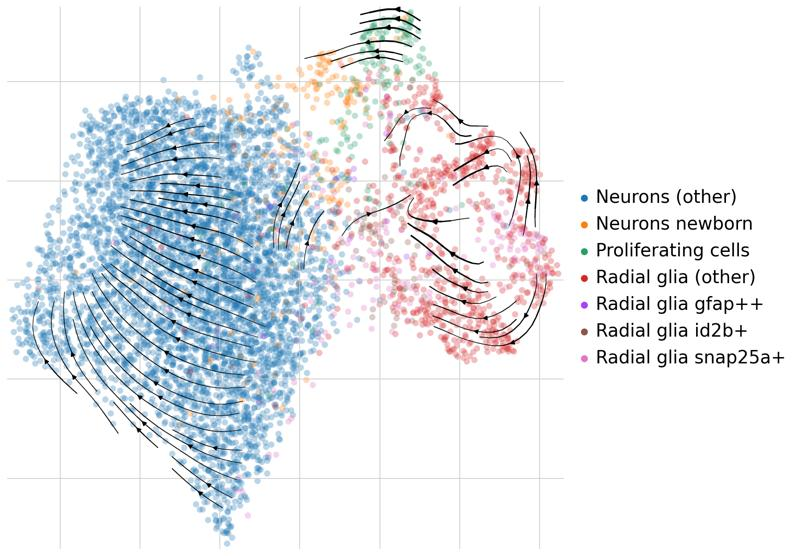

In [97]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, 
                                 title='', smooth=.8, min_mass=4, 
                                 color=['celltype_detailed_selective'],
                                 legend_loc='right margin', 
                                 figsize=[10,10])#, save='rhom_embstr_dct' #stochastic

In [99]:
# darker grey hue for RG other
col_celltype_detailed_sel = {'Neurons (other)' : '#ffffcc', 
                            'Radial glia (other)' : '#bababa',
                            'Neurons newborn' : '#ffff33',
                            'Proliferating cells' : '#ff7f00',
                            'Radial glia gfap++' : '#984ea3',
                            'Radial glia id2b+' : '#377eb8',
                            'Radial glia snap25a+' : '#e41a1c'}

saving figure to file ./figures/scvelo_rhom_embstr_dct_sel.png


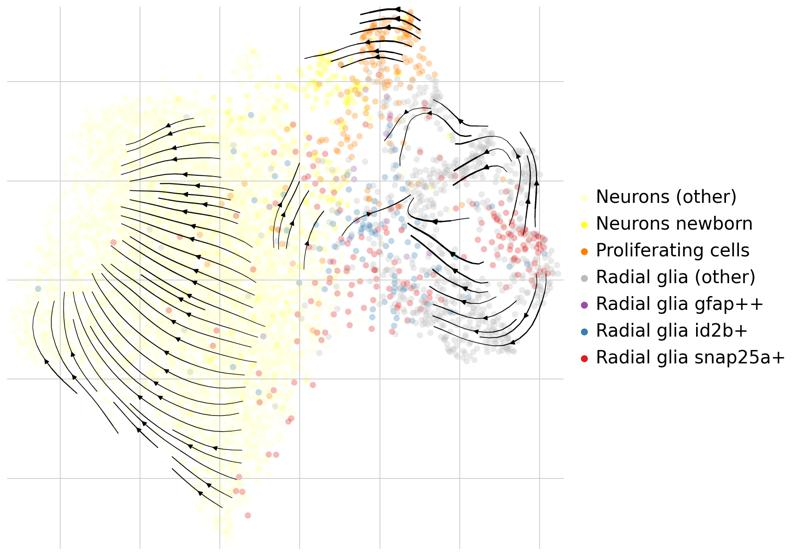

In [100]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, 
                                 title='', smooth=.8, min_mass=4, 
                                 color=['celltype_detailed_selective'],
                                 palette=col_celltype_detailed_sel,
                                 legend_loc='right margin', 
                                 figsize=[10,10],
                                 save='rhom_embstr_dct_sel.png')#,  #stochastic

##### Version 2 - highlight rhom-specific subtypes

In addition to global types present in tel, I also want to highlight the mes-specific subtypes, of which there are a few: prss35+, nrg1+, crabp1b+ and RP high.  
Also highlight the other abundant global type nppc+.  

In [5]:
celltype_detailed_selective_2 = rhom_rg_neu.obs.celltype_detailed

In [6]:
type(celltype_detailed_selective_2)

pandas.core.series.Series

In [7]:
celltype_detailed_selective_2

B18.R_AAACCCAAGGAGAGGC-1        Granule cells stxbp6l+ 
B18.R_AAACCCACAAGCACAG-1    Neurons glutamatargic (tel)
B18.R_AAACCCACAGGGAGAG-1                  Granule cells
B18.R_AAACGAAAGTTGCCTA-1                  Granule cells
B18.R_AAACGAACAATTGAGA-1           Granule cells (rhom)
                                       ...             
B18.R_TTTCGATTCGCCAATA-1              Radial glia nppc+
B18.R_TTTGATCCACTCTGCT-1      Proliferating cells mcm6+
B18.R_TTTGGAGTCAATCCGA-1     Radial glia prss35+ (rhom)
B18.R_TTTGGAGTCTACTTCA-1     Radial glia prss35+ (rhom)
B18.R_TTTGTTGCAGCGCGTT-1     Radial glia prss35+ (rhom)
Name: celltype_detailed, Length: 5917, dtype: category
Categories (37, object): ['Granule cells', 'Granule cells (mes)', 'Granule cells (rhom)', 'Granule cells stxbp6l+ ', ..., 'Radial glia ntn1b+ (dien)', 'Radial glia prss35+ (rhom)', 'Radial glia snap25a+', 'Radial glia stat2+']

In [8]:
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells (mes)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells (rhom)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells stxbp6l+ ', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells tcima+', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Granule cells tcima+ (dien)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Habenula dorsal (dien)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Habenula ventral (dien)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neuroepithelial cells', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons gabaergic (mes)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons gabaergic (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons gabaergic cort+ (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons gabaergic pax6b+ (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons gabaergic penkb+ (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons glutamatargic (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons glutamatergic lhx9+', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons glutamatergic/granule cells (tel)', 'Neurons (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons hypothalamus (dien)', 'Neurons (other)')

celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons newborn bnc2+', 'Neurons newborn')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Neurons newborn neurod1+', 'Neurons newborn')

celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Proliferating cells mcm6+', 'Proliferating cells')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Proliferating cells mki67+', 'Proliferating cells')

celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Purkinje neurons', 'Neurons (other)')

#celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia RP high(rhom)', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia apof+ (mes)', 'Radial glia (other)')
#celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia crabp1b+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia enkur+', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia foxn4+ (mes)', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia id3+ (dien)', 'Radial glia (other)')
#celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia nppc+', 'Radial glia (other)')
#celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia nrg1+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia ntn1b+ (dien)', 'Radial glia (other)')
#celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia prss35+ (rhom)', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia stat2+', 'Radial glia (other)')
celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia stra6+ (mes)', 'Radial glia (other)')

celltype_detailed_selective_2 = celltype_detailed_selective_2.replace('Radial glia gfap++', 'Radial glia her4++')


In [9]:
celltype_detailed_selective_2

B18.R_AAACCCAAGGAGAGGC-1               Neurons (other)
B18.R_AAACCCACAAGCACAG-1               Neurons (other)
B18.R_AAACCCACAGGGAGAG-1               Neurons (other)
B18.R_AAACGAAAGTTGCCTA-1               Neurons (other)
B18.R_AAACGAACAATTGAGA-1               Neurons (other)
                                       ...            
B18.R_TTTCGATTCGCCAATA-1             Radial glia nppc+
B18.R_TTTGATCCACTCTGCT-1           Proliferating cells
B18.R_TTTGGAGTCAATCCGA-1    Radial glia prss35+ (rhom)
B18.R_TTTGGAGTCTACTTCA-1    Radial glia prss35+ (rhom)
B18.R_TTTGTTGCAGCGCGTT-1    Radial glia prss35+ (rhom)
Name: celltype_detailed, Length: 5917, dtype: category
Categories (12, object): ['Neurons (other)', 'Neurons newborn', 'Proliferating cells', 'Radial glia RP high(rhom)', ..., 'Radial glia nppc+', 'Radial glia nrg1+ (rhom)', 'Radial glia prss35+ (rhom)', 'Radial glia snap25a+']

In [10]:
rhom_rg_neu.obs['celltype_detailed_selective_2'] = pd.Categorical(celltype_detailed_selective_2)

In [11]:
rhom_rg_neu.obs

orig_barcode fixation celltype_major  \
B18.R_AAACCCAAGGAGAGGC-1  b18_rhom:AAACCCAAGGAGAGGCx    fresh        Neurons   
B18.R_AAACCCACAAGCACAG-1  b18_rhom:AAACCCACAAGCACAGx    fresh        Neurons   
B18.R_AAACCCACAGGGAGAG-1  b18_rhom:AAACCCACAGGGAGAGx    fresh        Neurons   
B18.R_AAACGAAAGTTGCCTA-1  b18_rhom:AAACGAAAGTTGCCTAx    fresh        Neurons   
B18.R_AAACGAACAATTGAGA-1  b18_rhom:AAACGAACAATTGAGAx    fresh        Neurons   
...                                              ...      ...            ...   
B18.R_TTTCGATTCGCCAATA-1  b18_rhom:TTTCGATTCGCCAATAx    fresh    Radial glia   
B18.R_TTTGATCCACTCTGCT-1  b18_rhom:TTTGATCCACTCTGCTx    fresh    Radial glia   
B18.R_TTTGGAGTCAATCCGA-1  b18_rhom:TTTGGAGTCAATCCGAx    fresh    Radial glia   
B18.R_TTTGGAGTCTACTTCA-1  b18_rhom:TTTGGAGTCTACTTCAx    fresh    Radial glia   
B18.R_TTTGTTGCAGCGCGTT-1  b18_rhom:TTTGTTGCAGCGCGTTx    fresh    Radial glia   

                                    celltype_detailed celltype_detailed_short  \
B18.R_AAACCCAAGGAGAGGC-1      Granule cells stxbp6l+      Gran cells stxbp6l+   
B18.R_AAACCCACAAGCACAG-1  Neurons glutamatargic (tel)          Neu glut (tel)   
B18.R_AAACCCACAGGGAGAG-1                Granule cells              Gran cells   
B18.R_AAACGAAAGTTGCCTA-1                Granule cells              Gran cells   
B18.R_AAACGAACAATTGAGA-1         Granule cells (rhom)       Gran cells (rhom)   
...                                               ...                     ...   
B18.R_TTTCGATTCGCCAATA-1            Radial glia nppc+                RG nppc+   
B18.R_TTTGATCCACTCTGCT-1    Proliferating cells mcm6+              Prol mcm6+   
B18.R_TTTGGAGTCAATCCGA-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   
B18.R_TTTGGAGTCTACTTCA-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   
B18.R_TTTGTTGCAGCGCGTT-1   Radial glia prss35+ (rhom)       RG prss35+ (rhom)   

                         keep_in_final region_simple region_detailed  \
B18.R_AAACCCAAGGAGAGGC-1          True        Global           Multi   
B18.R_AAACCCACAAGCACAG-1          True      Regional             Tel   
B18.R_AAACCCACAGGGAGAG-1          True        Global           Multi   
B18.R_AAACGAAAGTTGCCTA-1          True        Global           Multi   
B18.R_AAACGAACAATTGAGA-1          True      Regional            Rhom   
...                                ...           ...             ...   
B18.R_TTTCGATTCGCCAATA-1          True        Global           Multi   
B18.R_TTTGATCCACTCTGCT-1          True  Global prol.           Multi   
B18.R_TTTGGAGTCAATCCGA-1          True      Regional            Rhom   
B18.R_TTTGGAGTCTACTTCA-1          True      Regional            Rhom   
B18.R_TTTGTTGCAGCGCGTT-1          True      Regional            Rhom   

                          region_score_max region_score_max_name  ...  leiden  \
B18.R_AAACCCAAGGAGAGGC-1              0.47             rhom_0.47  ...       2   
B18.R_AAACCCACAAGCACAG-1              0.91              tel_0.91  ...       2   
B18.R_AAACCCACAGGGAGAG-1              0.43             dien_0.43  ...      11   
B18.R_AAACGAAAGTTGCCTA-1              0.43             dien_0.43  ...       1   
B18.R_AAACGAACAATTGAGA-1              0.72             rhom_0.72  ...       1   
...                                    ...                   ...  ...     ...   
B18.R_TTTCGATTCGCCAATA-1              0.65             rhom_0.65  ...       8   
B18.R_TTTGATCCACTCTGCT-1              0.37              tel_0.37  ...      10   
B18.R_TTTGGAGTCAATCCGA-1              0.87             rhom_0.87  ...      14   
B18.R_TTTGGAGTCTACTTCA-1              0.87             rhom_0.87  ...      12   
B18.R_TTTGTTGCAGCGCGTT-1              0.87             rhom_0.87  ...      14   

                          cell_cycle_score  G2M_phase   S_phase  notch_score  \
B18.R_AAACCCAAGGAGAGGC-1         -0.014407  -0.020491 -0.008982    -0.022512   
B18.R_AAACCCACAAGCACAG-1          0.001623  -0.000921 -0.006545    -0.020398   
B18.R_AAACCCACAGGGAGAG-1    

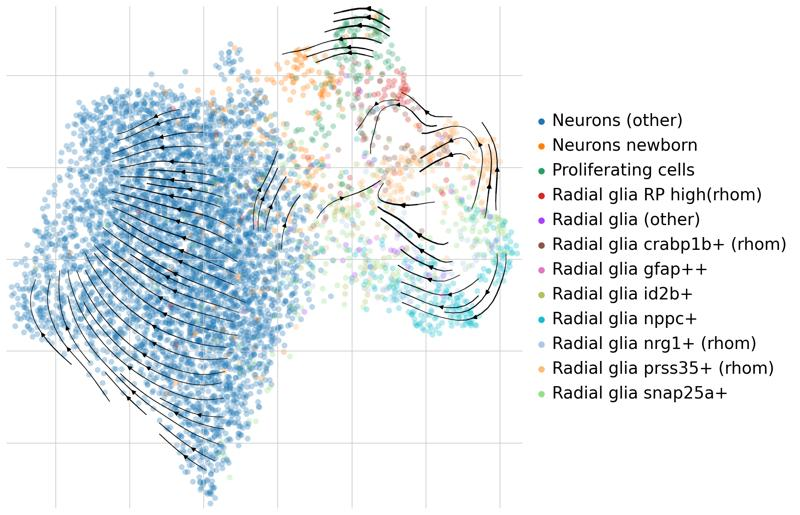

In [108]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, 
                                 title='', smooth=.8, min_mass=4, 
                                 color=['celltype_detailed_selective_2'],
                                 legend_loc='right margin', 
                                 figsize=[10,10])#, save='rhom_embstr_dct' #stochastic

In [12]:
# manually picked, most from Set1 pallette https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=8
# lighter hues yellow (Neurons (other)) from Pastel1
# darker grey hue for RG other

col_celltype_detailed_sel_2 = {'Neurons (other)' : '#ffffcc',                             
                               'Neurons newborn' : '#ffff33',
                            'Proliferating cells' : '#ff7f00',
                            'Radial glia RP high(rhom)' : '#4daf4a',
                            'Radial glia (other)' : '#bababa',
                            'Radial glia crabp1b+ (rhom)' : '#f781bf',
                            'Radial glia her4++' : '#984ea3',
                            'Radial glia id2b+' : '#377eb8',
                            'Radial glia nppc+' : '#a65628',
                            'Radial glia nrg1+ (rhom)' : '#e6ab02',
                            'Radial glia prss35+ (rhom)' : '#666666',
                            'Radial glia snap25a+' : '#e41a1c'
                              }

saving figure to file ./figures/scvelo_rhom_embstr_dct_sel_2.png


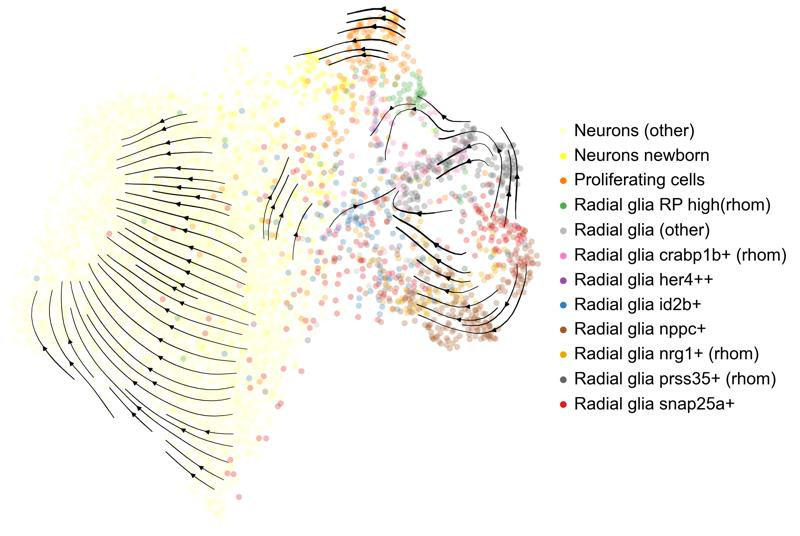

In [13]:
scv.pl.velocity_embedding_stream(rhom_rg_neu, basis='umap', legend_fontsize=18, 
                                 title='', smooth=.8, min_mass=4, 
                                 color=['celltype_detailed_selective_2'],
                                 palette=col_celltype_detailed_sel_2,
                                 legend_loc='right margin', 
                                 figsize=[10,10],
                                 save='rhom_embstr_dct_sel_2.png')#,  #stochastic